# Import and settings

In [13]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import logging
import logzero
from logzero import logger


# examination settings
batch_size = 128
test_batch_size = batch_size * 2
seed = 2017
num_workers = 2
use_gpu = False

# set seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# logger setting
LOG_FORMAT = '[%(asctime)s %(levelname)s] %(message)s'
logzero.loglevel(logging.INFO)
logzero.formatter(logging.Formatter(LOG_FORMAT))

# Prepare data

In [14]:
train_dataset = datasets.MNIST('./data/MNIST/train/', download=True, train=True)
test_dataset = datasets.MNIST('./data/MNIST/test/', download=True, train=False)

train_data = train_dataset.train_data.numpy()
test_data = test_dataset.test_data.numpy()
train_labels = train_dataset.train_labels.numpy()
test_labels = test_dataset.test_labels.numpy()

In [15]:
print(len(train_labels), len(test_labels))

60000 10000


## Change the ratio train/test
train:val:test を 1000:1000:68000に設定。各クラスのサンプル数は均一に。testセットは実際に教師なし学習に用いることは想定しづらいので、現実のタスクや論文に書く時はunlabeledデータとして説明すれば良い。その場合はtestセット内で更に unlabeled/holdout に分ける必要がある。
交差検証は行わない。

pseudo label実験に対してはtestデータはunlabeledデータ及び最終評価用のデータとして使われる。valは学習中の精度監視用。

In [16]:
n_train = 1000
n_val = 1000
n_test = 68000

X_train = np.empty(shape=(0, 28, 28))
y_train = np.empty(shape=(0,))
X_val = np.empty(shape=(0, 28, 28))
y_val = np.empty(shape=(0,))
X_test = np.empty(shape=(0, 28, 28))
y_test = np.empty(shape=(0,))

for i in range(10):
    idx_train = np.argwhere(train_labels == i)[:(n_train//10)].squeeze()
    idx_val = np.argwhere(train_labels == i)[(n_train//10):((n_train+n_val)//10)].squeeze()
    idx_test = np.argwhere(train_labels == i)[((n_train+n_val)//10):].squeeze()
    
    X_train = np.concatenate([X_train, train_data[idx_train]], axis=0)
    y_train = np.concatenate([y_train, train_labels[idx_train]], axis=0)
    X_val = np.concatenate([X_val, train_data[idx_val]], axis=0)
    y_val = np.concatenate([y_val, train_labels[idx_val]], axis=0)
    X_test = np.concatenate([X_test, train_data[idx_test]], axis=0)
    y_test = np.concatenate([y_test, train_labels[idx_test]], axis=0)
    
X_test = np.concatenate([X_test, test_data], axis=0)
y_test = np.concatenate([y_test, test_labels], axis=0)

# treat as image
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

# one-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

In [17]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1000, 28, 28, 1) (1000, 10) (1000, 28, 28, 1) (1000, 10) (68000, 28, 28, 1) (68000, 10)


# Define a network

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = F.adaptive_max_pool2d(x, output_size=1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x

# Define Dataset, DataLoader

In [19]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        img = self.X[index]
        img = self.transform(img)
        target = torch.Tensor(self.y[index].astype(float))
        return img, target
    
    def __len__(self):
        return len(self.X)

# Define TrainingTracker

In [20]:
class TrainingTracker(object):
    def __init__(self):
        self.epoch = 0
        self.history = {
            'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []
        }
        self.reset()
        
    def reset(self):
        self.train_acc = 0
        self.train_loss = 0
        self.val_acc = 0
        self.val_loss = 0
        self.train_count = 0
        self.val_count = 0

    def update(self, train, acc, loss, n):
        if train:
            acc_sum = self.train_acc * self.train_count + acc * n
            loss_sum = self.train_loss * self.train_count + loss * n
            self.train_count += n
            self.train_acc = acc_sum / self.train_count
            self.train_loss = loss_sum / self.train_count
        else:
            acc_sum = self.val_acc * self.val_count + acc * n
            loss_sum = self.val_loss * self.val_count + loss * n
            self.val_count += n
            self.val_acc = acc_sum / self.val_count
            self.val_loss = loss_sum / self.val_count

    def plot_history(self):
        plt.plot(self.history['train_acc'])
        plt.plot(self.history['val_acc'])
        plt.title('model accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(['train_acc', 'val_acc'], loc='lower right')
        plt.show()

        plt.plot(self.history['train_loss'])
        plt.plot(self.history['val_loss'])
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['train_loss', 'val_loss'], loc='lower right')
        plt.show()

# Define train, validate, test function

In [21]:
def _train(model, data_loader, criterion, optimizer, tracker):
    model.train()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=True, acc=acc, loss=loss.data[0], n=len(X))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    logger.info(
        'Epoch: {tracker.epoch} | '
        'TrainAcc: {tracker.train_acc:.4f} | '
        'TrainLoss: {tracker.train_loss:.4f}'.format(
            tracker=tracker)
    )
    tracker.history['train_acc'].append(tracker.train_acc)
    tracker.history['train_loss'] .append(tracker.train_loss)
    tracker.reset()

def _validate(model, data_loader, criterion, tracker):
    model.eval()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=False, acc=acc, loss=loss.data[0], n=len(X))

    logger.info(
        'Epoch: {tracker.epoch} | '
        'ValAcc: {tracker.val_acc:.4f} | '
        'ValLoss: {tracker.val_loss:.4f} \n'.format(
            tracker=tracker)
    )
    tracker.history['val_acc'].append(tracker.val_acc)
    tracker.history['val_loss'].append(tracker.val_loss)
    tracker.reset()
    
def _test(model, data_loader, criterion, make_pl=False):
    model.eval()
    
    if make_pl:
        pseudo_label = np.empty((0, 10))
    
    acc_sum = 0
    loss_sum = 0
    for i, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc_sum += pred.eq(answer).sum()
        loss_sum += loss.data[0] * X.size(0)
        
        if make_pl:
            pseudo_label = np.concatenate([pseudo_label, output.data.numpy()], axis=0)

    acc = acc_sum / n_test
    loss = loss_sum / n_test
    logger.info(
        'TestAcc: {0:.4f} | '
        'TestLoss: {1:.4f} '.format(
            acc, loss)
    )
    
    if make_pl:
        pseudo_label = np.exp(pseudo_label)
        np.save('./save/pseudo_label_{}.npy'.format(ex_name), pseudo_label)
    
    return acc, loss

# Experimental

[2017-12-02 21:41:12,158 INFO] Epoch: 0 | TrainAcc: 0.1150 | TrainLoss: 0.2382
[2017-12-02 21:41:12,496 INFO] Epoch: 0 | ValAcc: 0.2330 | ValLoss: 0.2268 

[2017-12-02 21:41:13,300 INFO] Epoch: 1 | TrainAcc: 0.2480 | TrainLoss: 0.2186
[2017-12-02 21:41:13,680 INFO] Epoch: 1 | ValAcc: 0.1870 | ValLoss: 0.2185 

[2017-12-02 21:41:14,429 INFO] Epoch: 2 | TrainAcc: 0.2960 | TrainLoss: 0.2000
[2017-12-02 21:41:14,839 INFO] Epoch: 2 | ValAcc: 0.3630 | ValLoss: 0.1939 

[2017-12-02 21:41:15,571 INFO] Epoch: 3 | TrainAcc: 0.4270 | TrainLoss: 0.1703
[2017-12-02 21:41:15,935 INFO] Epoch: 3 | ValAcc: 0.3170 | ValLoss: 0.1920 

[2017-12-02 21:41:16,616 INFO] Epoch: 4 | TrainAcc: 0.5160 | TrainLoss: 0.1428
[2017-12-02 21:41:16,949 INFO] Epoch: 4 | ValAcc: 0.4780 | ValLoss: 0.1437 

[2017-12-02 21:41:17,660 INFO] Epoch: 5 | TrainAcc: 0.6230 | TrainLoss: 0.1156
[2017-12-02 21:41:17,993 INFO] Epoch: 5 | ValAcc: 0.5440 | ValLoss: 0.1255 

[2017-12-02 21:41:18,689 INFO] Epoch: 6 | TrainAcc: 0.6780 | Tra

[2017-12-02 21:42:05,613 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:42:05,918 INFO] Epoch: 52 | ValAcc: 0.8840 | ValLoss: 0.0399 

[2017-12-02 21:42:06,749 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:42:07,123 INFO] Epoch: 53 | ValAcc: 0.8840 | ValLoss: 0.0404 

[2017-12-02 21:42:07,799 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:42:08,173 INFO] Epoch: 54 | ValAcc: 0.8830 | ValLoss: 0.0407 

[2017-12-02 21:42:08,986 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:42:09,326 INFO] Epoch: 55 | ValAcc: 0.8820 | ValLoss: 0.0405 

[2017-12-02 21:42:10,092 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:42:10,429 INFO] Epoch: 56 | ValAcc: 0.8840 | ValLoss: 0.0402 

[2017-12-02 21:42:11,137 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:42:11,469 INFO] Epoch: 57 | ValAcc: 0.8830 | ValLoss: 0.0404 

[2017-12-02 21:42:12,165 INFO] Epoch: 58 | TrainAcc:

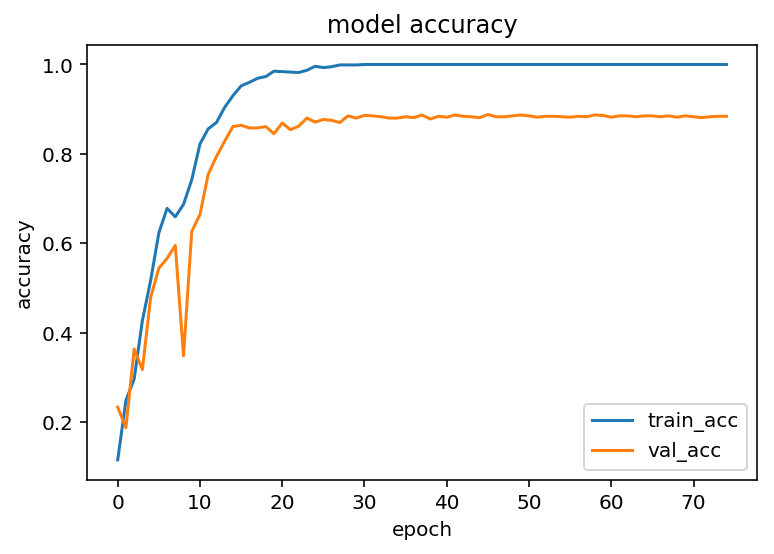

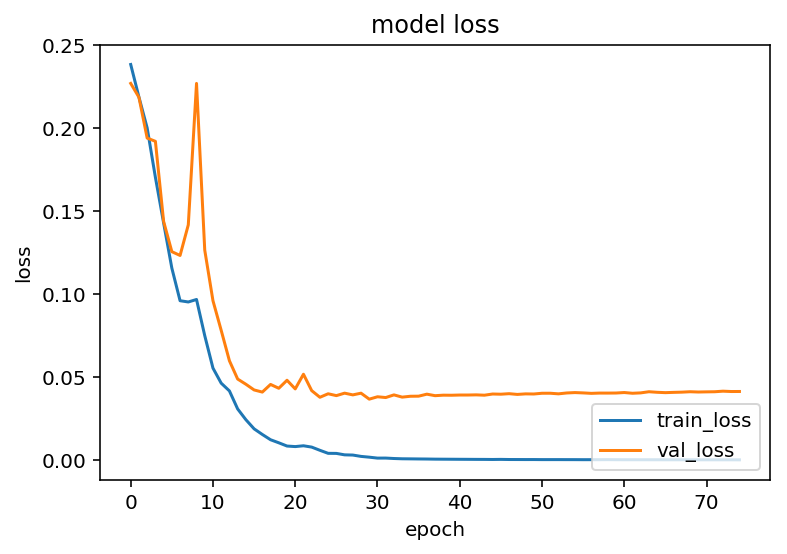

100%|██████████| 266/266 [00:13<00:00, 19.67it/s]
[2017-12-02 21:42:42,770 INFO] TestAcc: 0.8940 | TestLoss: 0.0371 
[2017-12-02 21:42:43,407 INFO] Epoch: 0 | TrainAcc: 0.1160 | TrainLoss: 0.2337
[2017-12-02 21:42:43,713 INFO] Epoch: 0 | ValAcc: 0.1060 | ValLoss: 0.2285 

[2017-12-02 21:42:44,377 INFO] Epoch: 1 | TrainAcc: 0.3060 | TrainLoss: 0.2121
[2017-12-02 21:42:44,756 INFO] Epoch: 1 | ValAcc: 0.2410 | ValLoss: 0.2161 

[2017-12-02 21:42:45,522 INFO] Epoch: 2 | TrainAcc: 0.4470 | TrainLoss: 0.1899
[2017-12-02 21:42:45,903 INFO] Epoch: 2 | ValAcc: 0.4080 | ValLoss: 0.1841 

[2017-12-02 21:42:46,600 INFO] Epoch: 3 | TrainAcc: 0.5120 | TrainLoss: 0.1549
[2017-12-02 21:42:46,945 INFO] Epoch: 3 | ValAcc: 0.3340 | ValLoss: 0.1909 

[2017-12-02 21:42:47,587 INFO] Epoch: 4 | TrainAcc: 0.6320 | TrainLoss: 0.1170
[2017-12-02 21:42:47,919 INFO] Epoch: 4 | ValAcc: 0.4710 | ValLoss: 0.1552 

[2017-12-02 21:42:48,548 INFO] Epoch: 5 | TrainAcc: 0.6460 | TrainLoss: 0.1013
[2017-12-02 21:42:48,878

[2017-12-02 21:43:36,661 INFO] Epoch: 51 | ValAcc: 0.8870 | ValLoss: 0.0400 

[2017-12-02 21:43:37,305 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:43:37,616 INFO] Epoch: 52 | ValAcc: 0.8930 | ValLoss: 0.0399 

[2017-12-02 21:43:38,260 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:43:38,565 INFO] Epoch: 53 | ValAcc: 0.8880 | ValLoss: 0.0399 

[2017-12-02 21:43:39,184 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:43:39,485 INFO] Epoch: 54 | ValAcc: 0.8920 | ValLoss: 0.0400 

[2017-12-02 21:43:39,499 INFO] Accuracy dose not improve for a long epochs
[2017-12-02 21:43:39,501 INFO] Train done.
[2017-12-02 21:43:39,502 INFO] Elapsed Time: 56.712230920791626


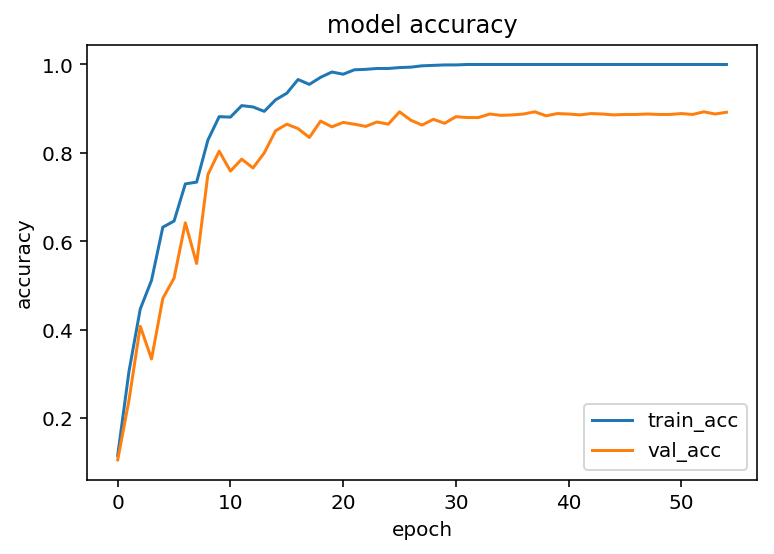

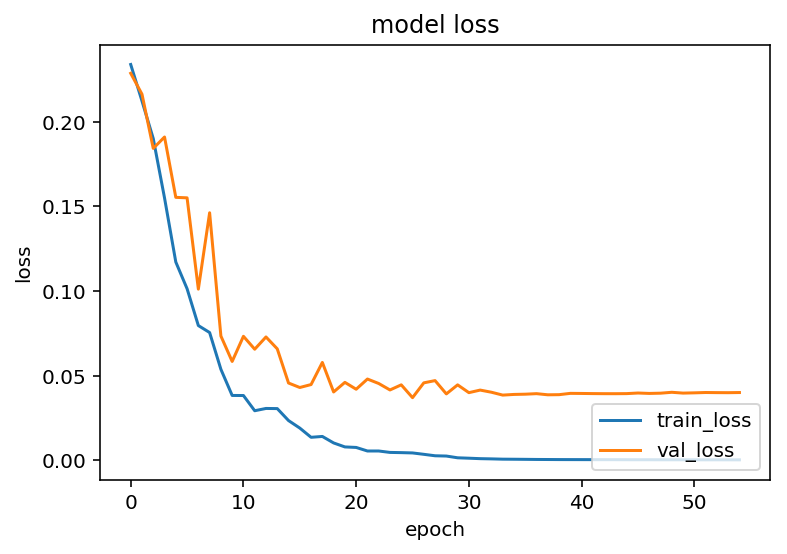

100%|██████████| 266/266 [00:12<00:00, 20.55it/s]
[2017-12-02 21:43:52,696 INFO] TestAcc: 0.8962 | TestLoss: 0.0339 
[2017-12-02 21:43:53,321 INFO] Epoch: 0 | TrainAcc: 0.1220 | TrainLoss: 0.2405
[2017-12-02 21:43:53,610 INFO] Epoch: 0 | ValAcc: 0.2120 | ValLoss: 0.2279 

[2017-12-02 21:43:54,237 INFO] Epoch: 1 | TrainAcc: 0.1870 | TrainLoss: 0.2191
[2017-12-02 21:43:54,539 INFO] Epoch: 1 | ValAcc: 0.2310 | ValLoss: 0.2198 

[2017-12-02 21:43:55,175 INFO] Epoch: 2 | TrainAcc: 0.3250 | TrainLoss: 0.1989
[2017-12-02 21:43:55,479 INFO] Epoch: 2 | ValAcc: 0.2920 | ValLoss: 0.1981 

[2017-12-02 21:43:56,103 INFO] Epoch: 3 | TrainAcc: 0.4340 | TrainLoss: 0.1683
[2017-12-02 21:43:56,410 INFO] Epoch: 3 | ValAcc: 0.4920 | ValLoss: 0.1582 

[2017-12-02 21:43:57,027 INFO] Epoch: 4 | TrainAcc: 0.5740 | TrainLoss: 0.1359
[2017-12-02 21:43:57,330 INFO] Epoch: 4 | ValAcc: 0.3730 | ValLoss: 0.1791 

[2017-12-02 21:43:57,953 INFO] Epoch: 5 | TrainAcc: 0.6400 | TrainLoss: 0.1120
[2017-12-02 21:43:58,252

[2017-12-02 21:44:40,819 INFO] Epoch: 51 | ValAcc: 0.8690 | ValLoss: 0.0456 

[2017-12-02 21:44:41,430 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:44:41,719 INFO] Epoch: 52 | ValAcc: 0.8680 | ValLoss: 0.0466 

[2017-12-02 21:44:42,356 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:44:42,667 INFO] Epoch: 53 | ValAcc: 0.8690 | ValLoss: 0.0465 

[2017-12-02 21:44:43,280 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:44:43,581 INFO] Epoch: 54 | ValAcc: 0.8680 | ValLoss: 0.0467 

[2017-12-02 21:44:44,210 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:44:44,537 INFO] Epoch: 55 | ValAcc: 0.8710 | ValLoss: 0.0465 

[2017-12-02 21:44:45,169 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:44:45,476 INFO] Epoch: 56 | ValAcc: 0.8670 | ValLoss: 0.0470 

[2017-12-02 21:44:46,099 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:44:46,395 INFO] Epoch: 57 | ValAcc: 0

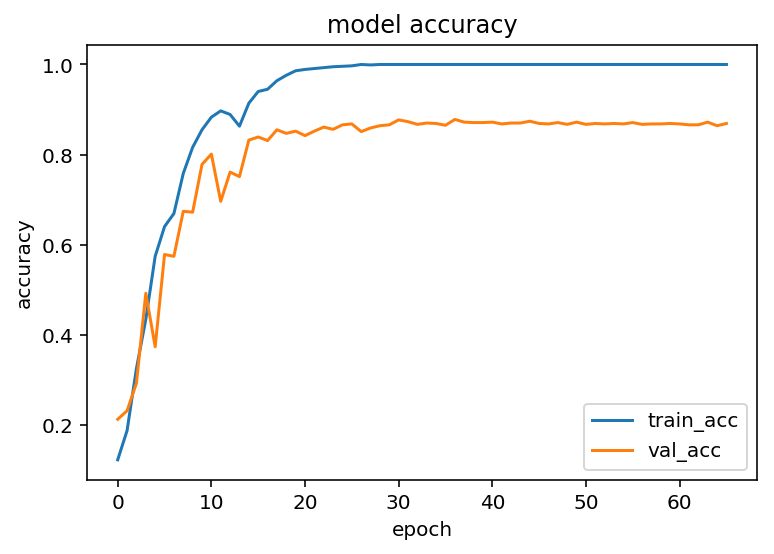

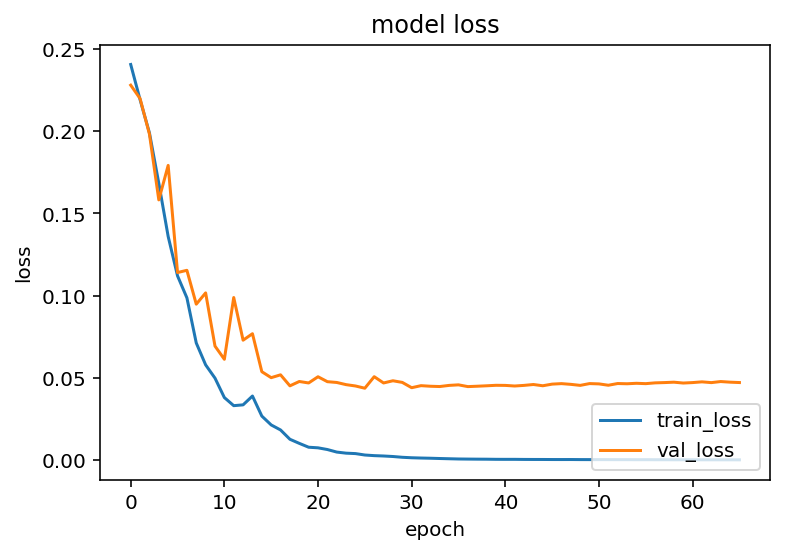

100%|██████████| 266/266 [00:12<00:00, 20.92it/s]
[2017-12-02 21:45:06,795 INFO] TestAcc: 0.8829 | TestLoss: 0.0427 
[2017-12-02 21:45:07,419 INFO] Epoch: 0 | TrainAcc: 0.1300 | TrainLoss: 0.2310
[2017-12-02 21:45:07,717 INFO] Epoch: 0 | ValAcc: 0.1570 | ValLoss: 0.2270 

[2017-12-02 21:45:08,333 INFO] Epoch: 1 | TrainAcc: 0.3520 | TrainLoss: 0.2052
[2017-12-02 21:45:08,631 INFO] Epoch: 1 | ValAcc: 0.3050 | ValLoss: 0.2102 

[2017-12-02 21:45:09,245 INFO] Epoch: 2 | TrainAcc: 0.4800 | TrainLoss: 0.1689
[2017-12-02 21:45:09,542 INFO] Epoch: 2 | ValAcc: 0.4740 | ValLoss: 0.1696 

[2017-12-02 21:45:10,166 INFO] Epoch: 3 | TrainAcc: 0.6560 | TrainLoss: 0.1258
[2017-12-02 21:45:10,459 INFO] Epoch: 3 | ValAcc: 0.5720 | ValLoss: 0.1261 

[2017-12-02 21:45:11,082 INFO] Epoch: 4 | TrainAcc: 0.7550 | TrainLoss: 0.0892
[2017-12-02 21:45:11,400 INFO] Epoch: 4 | ValAcc: 0.5410 | ValLoss: 0.1357 

[2017-12-02 21:45:12,032 INFO] Epoch: 5 | TrainAcc: 0.7670 | TrainLoss: 0.0755
[2017-12-02 21:45:12,330

[2017-12-02 21:45:54,994 INFO] Epoch: 51 | ValAcc: 0.8990 | ValLoss: 0.0359 

[2017-12-02 21:45:55,630 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:45:55,941 INFO] Epoch: 52 | ValAcc: 0.9020 | ValLoss: 0.0364 

[2017-12-02 21:45:56,560 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:45:56,864 INFO] Epoch: 53 | ValAcc: 0.9010 | ValLoss: 0.0363 

[2017-12-02 21:45:57,489 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:45:57,794 INFO] Epoch: 54 | ValAcc: 0.9030 | ValLoss: 0.0360 

[2017-12-02 21:45:58,420 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:45:58,715 INFO] Epoch: 55 | ValAcc: 0.9010 | ValLoss: 0.0362 

[2017-12-02 21:45:59,347 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:45:59,641 INFO] Epoch: 56 | ValAcc: 0.8980 | ValLoss: 0.0363 

[2017-12-02 21:46:00,257 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:46:00,559 INFO] Epoch: 57 | ValAcc: 0

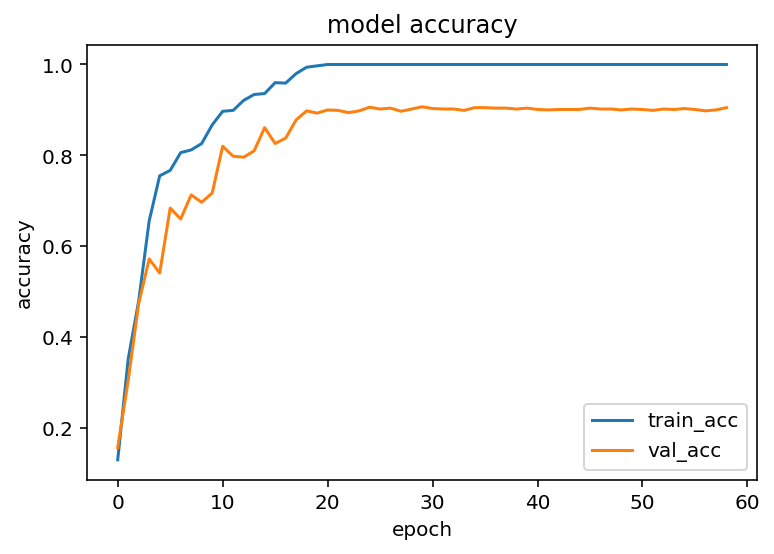

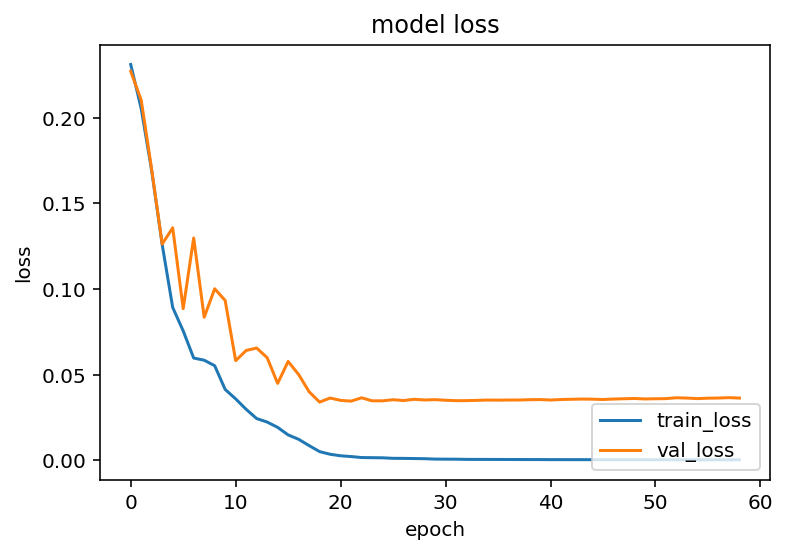

100%|██████████| 266/266 [00:14<00:00, 19.00it/s]
[2017-12-02 21:46:15,756 INFO] TestAcc: 0.9015 | TestLoss: 0.0334 
[2017-12-02 21:46:16,510 INFO] Epoch: 0 | TrainAcc: 0.1020 | TrainLoss: 0.2456
[2017-12-02 21:46:16,915 INFO] Epoch: 0 | ValAcc: 0.1000 | ValLoss: 0.2305 

[2017-12-02 21:46:17,730 INFO] Epoch: 1 | TrainAcc: 0.1880 | TrainLoss: 0.2245
[2017-12-02 21:46:18,118 INFO] Epoch: 1 | ValAcc: 0.2470 | ValLoss: 0.2227 

[2017-12-02 21:46:18,972 INFO] Epoch: 2 | TrainAcc: 0.3140 | TrainLoss: 0.2095
[2017-12-02 21:46:19,325 INFO] Epoch: 2 | ValAcc: 0.3110 | ValLoss: 0.2075 

[2017-12-02 21:46:20,007 INFO] Epoch: 3 | TrainAcc: 0.4700 | TrainLoss: 0.1833
[2017-12-02 21:46:20,343 INFO] Epoch: 3 | ValAcc: 0.3530 | ValLoss: 0.1812 

[2017-12-02 21:46:20,971 INFO] Epoch: 4 | TrainAcc: 0.5310 | TrainLoss: 0.1505
[2017-12-02 21:46:21,284 INFO] Epoch: 4 | ValAcc: 0.4840 | ValLoss: 0.1478 

[2017-12-02 21:46:21,963 INFO] Epoch: 5 | TrainAcc: 0.6490 | TrainLoss: 0.1154
[2017-12-02 21:46:22,283

[2017-12-02 21:47:09,103 INFO] Epoch: 51 | ValAcc: 0.8660 | ValLoss: 0.0507 

[2017-12-02 21:47:09,744 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:47:10,063 INFO] Epoch: 52 | ValAcc: 0.8630 | ValLoss: 0.0511 

[2017-12-02 21:47:10,679 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:47:11,004 INFO] Epoch: 53 | ValAcc: 0.8650 | ValLoss: 0.0514 

[2017-12-02 21:47:11,752 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:47:12,172 INFO] Epoch: 54 | ValAcc: 0.8660 | ValLoss: 0.0515 

[2017-12-02 21:47:12,904 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:47:13,231 INFO] Epoch: 55 | ValAcc: 0.8640 | ValLoss: 0.0515 

[2017-12-02 21:47:13,890 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:47:14,249 INFO] Epoch: 56 | ValAcc: 0.8640 | ValLoss: 0.0514 

[2017-12-02 21:47:14,878 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:47:15,197 INFO] Epoch: 57 | ValAcc: 0

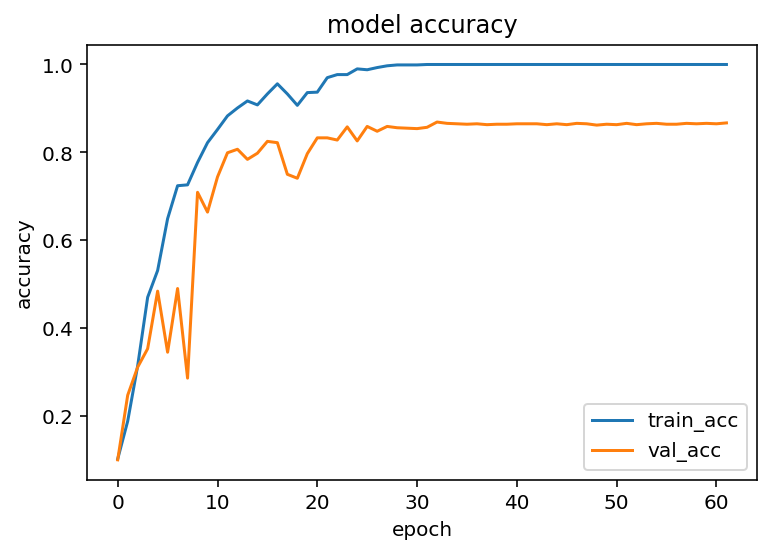

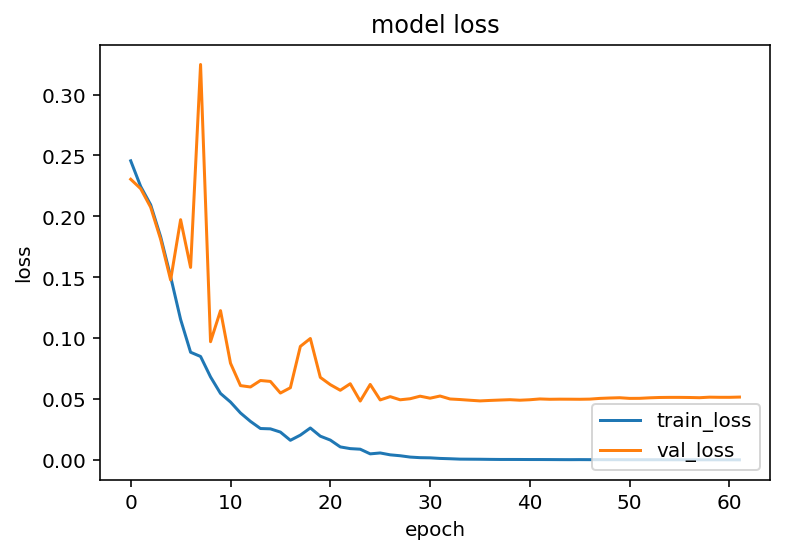

100%|██████████| 266/266 [00:13<00:00, 20.23it/s]
[2017-12-02 21:47:32,378 INFO] TestAcc: 0.8706 | TestLoss: 0.0459 
[2017-12-02 21:47:33,010 INFO] Epoch: 0 | TrainAcc: 0.1250 | TrainLoss: 0.2402
[2017-12-02 21:47:33,315 INFO] Epoch: 0 | ValAcc: 0.1100 | ValLoss: 0.2302 

[2017-12-02 21:47:33,956 INFO] Epoch: 1 | TrainAcc: 0.1500 | TrainLoss: 0.2257
[2017-12-02 21:47:34,300 INFO] Epoch: 1 | ValAcc: 0.2310 | ValLoss: 0.2243 

[2017-12-02 21:47:34,933 INFO] Epoch: 2 | TrainAcc: 0.2820 | TrainLoss: 0.2140
[2017-12-02 21:47:35,277 INFO] Epoch: 2 | ValAcc: 0.3290 | ValLoss: 0.2110 

[2017-12-02 21:47:35,945 INFO] Epoch: 3 | TrainAcc: 0.4500 | TrainLoss: 0.1904
[2017-12-02 21:47:36,281 INFO] Epoch: 3 | ValAcc: 0.3430 | ValLoss: 0.1908 

[2017-12-02 21:47:36,940 INFO] Epoch: 4 | TrainAcc: 0.5430 | TrainLoss: 0.1544
[2017-12-02 21:47:37,261 INFO] Epoch: 4 | ValAcc: 0.5490 | ValLoss: 0.1450 

[2017-12-02 21:47:37,923 INFO] Epoch: 5 | TrainAcc: 0.6790 | TrainLoss: 0.1122
[2017-12-02 21:47:38,231

[2017-12-02 21:48:26,020 INFO] Epoch: 51 | ValAcc: 0.8630 | ValLoss: 0.0520 

[2017-12-02 21:48:26,672 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:48:26,985 INFO] Epoch: 52 | ValAcc: 0.8560 | ValLoss: 0.0525 

[2017-12-02 21:48:27,661 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:48:28,013 INFO] Epoch: 53 | ValAcc: 0.8620 | ValLoss: 0.0521 

[2017-12-02 21:48:28,716 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:48:29,070 INFO] Epoch: 54 | ValAcc: 0.8640 | ValLoss: 0.0519 

[2017-12-02 21:48:29,828 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:48:30,152 INFO] Epoch: 55 | ValAcc: 0.8620 | ValLoss: 0.0526 

[2017-12-02 21:48:30,816 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:48:31,171 INFO] Epoch: 56 | ValAcc: 0.8610 | ValLoss: 0.0528 

[2017-12-02 21:48:31,899 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:48:32,237 INFO] Epoch: 57 | ValAcc: 0

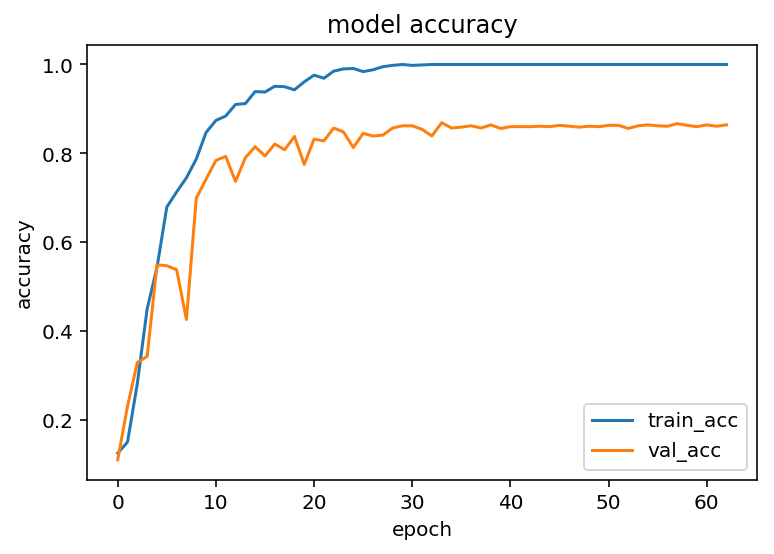

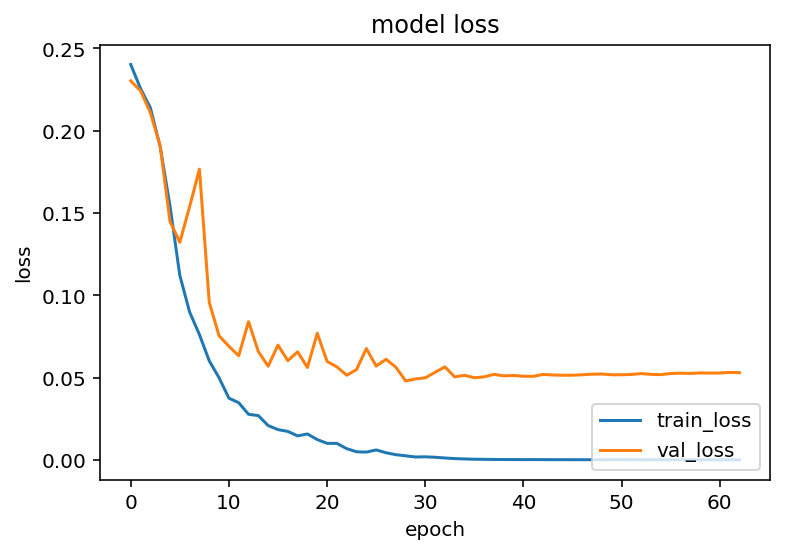

100%|██████████| 266/266 [00:15<00:00, 16.64it/s]
[2017-12-02 21:48:53,937 INFO] TestAcc: 0.8858 | TestLoss: 0.0401 
[2017-12-02 21:48:54,580 INFO] Epoch: 0 | TrainAcc: 0.1570 | TrainLoss: 0.2324
[2017-12-02 21:48:54,882 INFO] Epoch: 0 | ValAcc: 0.1740 | ValLoss: 0.2260 

[2017-12-02 21:48:55,617 INFO] Epoch: 1 | TrainAcc: 0.2380 | TrainLoss: 0.2127
[2017-12-02 21:48:55,937 INFO] Epoch: 1 | ValAcc: 0.3050 | ValLoss: 0.2091 

[2017-12-02 21:48:56,713 INFO] Epoch: 2 | TrainAcc: 0.4030 | TrainLoss: 0.1826
[2017-12-02 21:48:57,126 INFO] Epoch: 2 | ValAcc: 0.3000 | ValLoss: 0.1863 

[2017-12-02 21:48:57,793 INFO] Epoch: 3 | TrainAcc: 0.5110 | TrainLoss: 0.1481
[2017-12-02 21:48:58,243 INFO] Epoch: 3 | ValAcc: 0.3080 | ValLoss: 0.1902 

[2017-12-02 21:48:58,942 INFO] Epoch: 4 | TrainAcc: 0.5740 | TrainLoss: 0.1261
[2017-12-02 21:48:59,271 INFO] Epoch: 4 | ValAcc: 0.5920 | ValLoss: 0.1252 

[2017-12-02 21:48:59,936 INFO] Epoch: 5 | TrainAcc: 0.7060 | TrainLoss: 0.0902
[2017-12-02 21:49:00,248

[2017-12-02 21:49:46,959 INFO] Epoch: 51 | ValAcc: 0.8850 | ValLoss: 0.0381 

[2017-12-02 21:49:47,585 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:49:47,886 INFO] Epoch: 52 | ValAcc: 0.8820 | ValLoss: 0.0379 

[2017-12-02 21:49:48,511 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:49:48,803 INFO] Epoch: 53 | ValAcc: 0.8820 | ValLoss: 0.0377 

[2017-12-02 21:49:49,410 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:49:49,711 INFO] Epoch: 54 | ValAcc: 0.8840 | ValLoss: 0.0380 

[2017-12-02 21:49:50,341 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:49:50,654 INFO] Epoch: 55 | ValAcc: 0.8840 | ValLoss: 0.0382 

[2017-12-02 21:49:51,278 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:49:51,573 INFO] Epoch: 56 | ValAcc: 0.8780 | ValLoss: 0.0383 

[2017-12-02 21:49:52,210 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:49:52,511 INFO] Epoch: 57 | ValAcc: 0

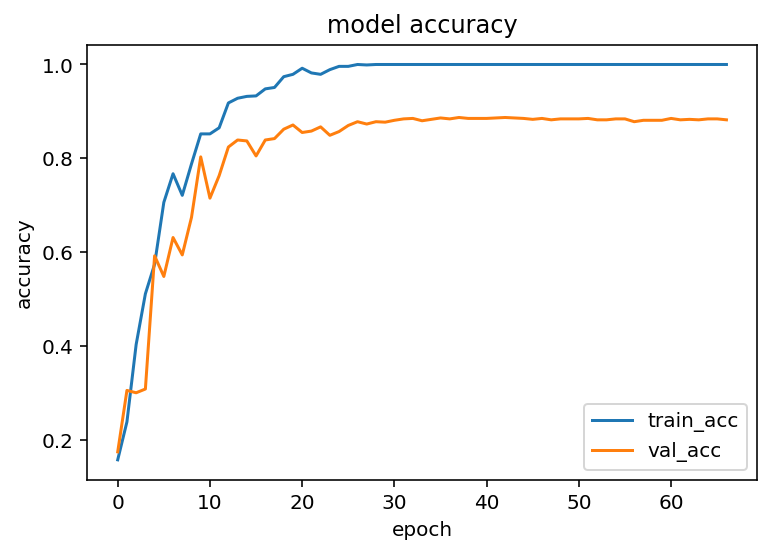

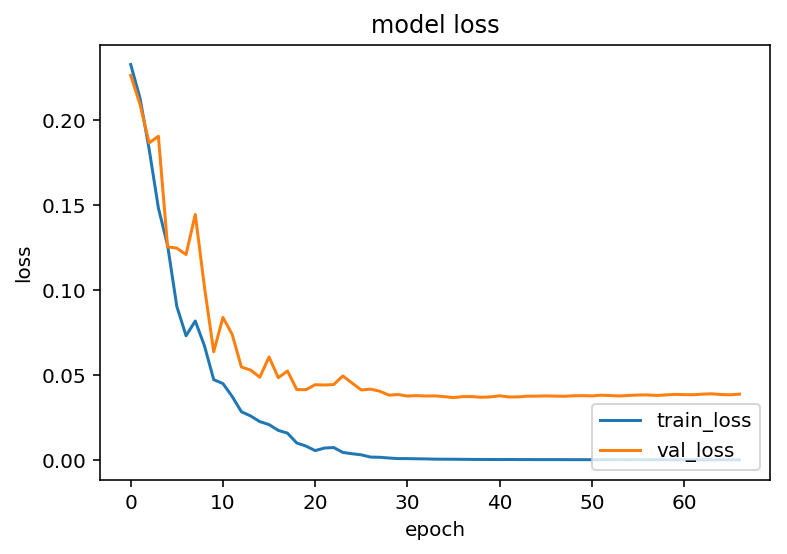

100%|██████████| 266/266 [00:13<00:00, 19.24it/s]
[2017-12-02 21:50:15,002 INFO] TestAcc: 0.9047 | TestLoss: 0.0337 
[2017-12-02 21:50:15,828 INFO] Epoch: 0 | TrainAcc: 0.1510 | TrainLoss: 0.2347
[2017-12-02 21:50:16,190 INFO] Epoch: 0 | ValAcc: 0.2040 | ValLoss: 0.2280 

[2017-12-02 21:50:17,003 INFO] Epoch: 1 | TrainAcc: 0.2510 | TrainLoss: 0.2123
[2017-12-02 21:50:17,307 INFO] Epoch: 1 | ValAcc: 0.2840 | ValLoss: 0.2158 

[2017-12-02 21:50:18,005 INFO] Epoch: 2 | TrainAcc: 0.3850 | TrainLoss: 0.1842
[2017-12-02 21:50:18,316 INFO] Epoch: 2 | ValAcc: 0.3650 | ValLoss: 0.1837 

[2017-12-02 21:50:18,941 INFO] Epoch: 3 | TrainAcc: 0.4920 | TrainLoss: 0.1506
[2017-12-02 21:50:19,242 INFO] Epoch: 3 | ValAcc: 0.3870 | ValLoss: 0.1521 

[2017-12-02 21:50:19,871 INFO] Epoch: 4 | TrainAcc: 0.5670 | TrainLoss: 0.1248
[2017-12-02 21:50:20,180 INFO] Epoch: 4 | ValAcc: 0.5570 | ValLoss: 0.1185 

[2017-12-02 21:50:20,823 INFO] Epoch: 5 | TrainAcc: 0.7270 | TrainLoss: 0.0851
[2017-12-02 21:50:21,175

[2017-12-02 21:51:07,396 INFO] Epoch: 51 | ValAcc: 0.8930 | ValLoss: 0.0391 

[2017-12-02 21:51:08,030 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:51:08,339 INFO] Epoch: 52 | ValAcc: 0.8900 | ValLoss: 0.0396 

[2017-12-02 21:51:08,957 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:51:09,260 INFO] Epoch: 53 | ValAcc: 0.8910 | ValLoss: 0.0395 

[2017-12-02 21:51:09,883 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:51:10,187 INFO] Epoch: 54 | ValAcc: 0.8870 | ValLoss: 0.0393 

[2017-12-02 21:51:10,817 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:51:11,189 INFO] Epoch: 55 | ValAcc: 0.8920 | ValLoss: 0.0402 

[2017-12-02 21:51:12,003 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:51:12,327 INFO] Epoch: 56 | ValAcc: 0.8920 | ValLoss: 0.0395 

[2017-12-02 21:51:13,138 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:51:13,440 INFO] Epoch: 57 | ValAcc: 0

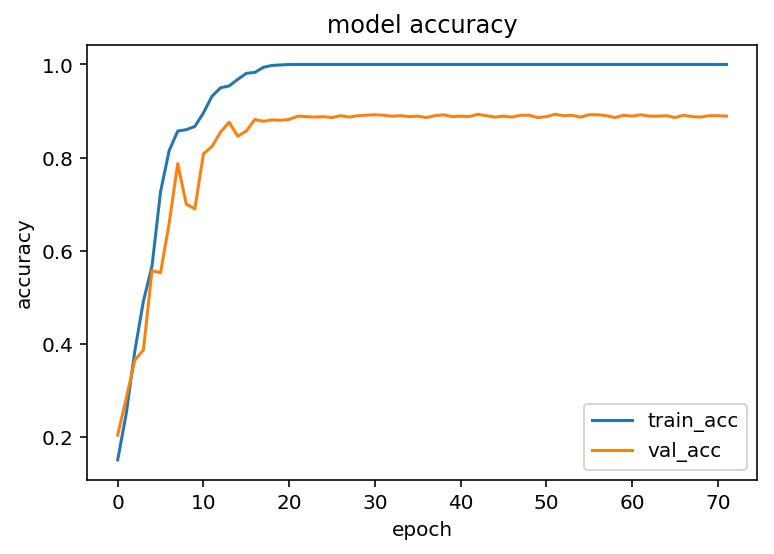

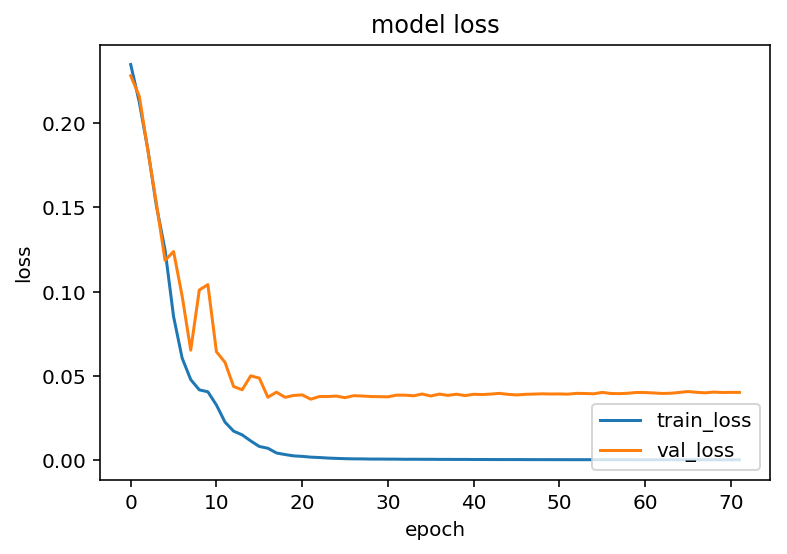

100%|██████████| 266/266 [00:13<00:00, 19.31it/s]
[2017-12-02 21:51:42,052 INFO] TestAcc: 0.8965 | TestLoss: 0.0376 
[2017-12-02 21:51:42,727 INFO] Epoch: 0 | TrainAcc: 0.1520 | TrainLoss: 0.2371
[2017-12-02 21:51:43,036 INFO] Epoch: 0 | ValAcc: 0.1010 | ValLoss: 0.2276 

[2017-12-02 21:51:43,683 INFO] Epoch: 1 | TrainAcc: 0.2500 | TrainLoss: 0.2194
[2017-12-02 21:51:43,994 INFO] Epoch: 1 | ValAcc: 0.4840 | ValLoss: 0.2053 

[2017-12-02 21:51:44,656 INFO] Epoch: 2 | TrainAcc: 0.4310 | TrainLoss: 0.1788
[2017-12-02 21:51:44,963 INFO] Epoch: 2 | ValAcc: 0.4390 | ValLoss: 0.1774 

[2017-12-02 21:51:45,632 INFO] Epoch: 3 | TrainAcc: 0.6070 | TrainLoss: 0.1338
[2017-12-02 21:51:45,938 INFO] Epoch: 3 | ValAcc: 0.6130 | ValLoss: 0.1311 

[2017-12-02 21:51:46,553 INFO] Epoch: 4 | TrainAcc: 0.7560 | TrainLoss: 0.0902
[2017-12-02 21:51:46,870 INFO] Epoch: 4 | ValAcc: 0.7240 | ValLoss: 0.0947 

[2017-12-02 21:51:47,506 INFO] Epoch: 5 | TrainAcc: 0.7470 | TrainLoss: 0.0802
[2017-12-02 21:51:47,824

[2017-12-02 21:52:33,256 INFO] Epoch: 51 | ValAcc: 0.8830 | ValLoss: 0.0470 

[2017-12-02 21:52:33,933 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:52:34,253 INFO] Epoch: 52 | ValAcc: 0.8820 | ValLoss: 0.0470 

[2017-12-02 21:52:34,929 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:52:35,236 INFO] Epoch: 53 | ValAcc: 0.8790 | ValLoss: 0.0471 

[2017-12-02 21:52:35,878 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:52:36,205 INFO] Epoch: 54 | ValAcc: 0.8830 | ValLoss: 0.0469 

[2017-12-02 21:52:36,890 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:52:37,215 INFO] Epoch: 55 | ValAcc: 0.8800 | ValLoss: 0.0475 

[2017-12-02 21:52:37,895 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:52:38,272 INFO] Epoch: 56 | ValAcc: 0.8800 | ValLoss: 0.0472 

[2017-12-02 21:52:38,910 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:52:39,220 INFO] Epoch: 57 | ValAcc: 0

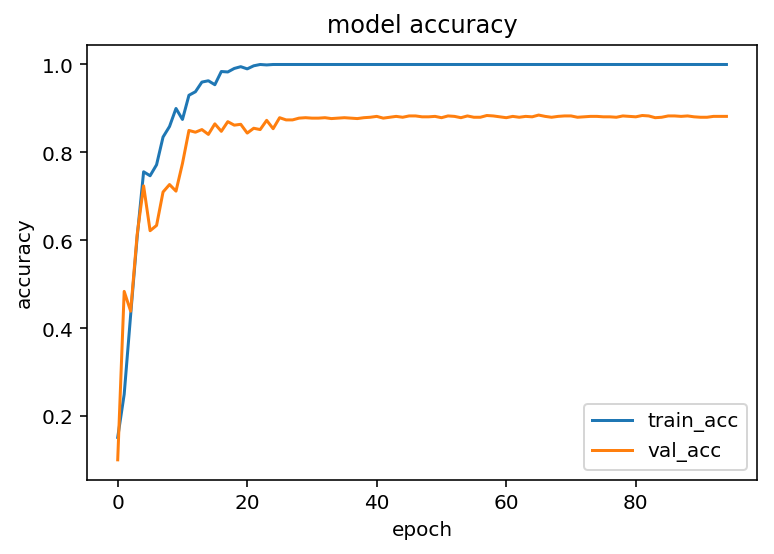

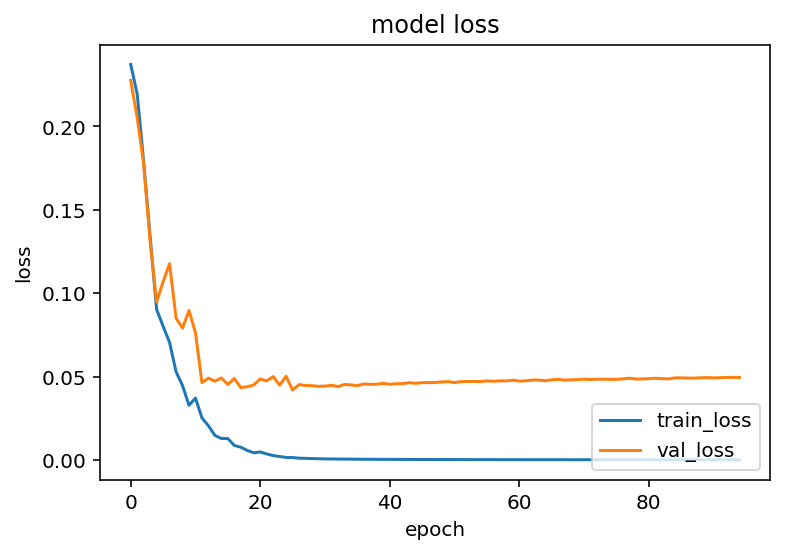

100%|██████████| 266/266 [00:13<00:00, 20.20it/s]
[2017-12-02 21:53:29,436 INFO] TestAcc: 0.8936 | TestLoss: 0.0402 
[2017-12-02 21:53:30,113 INFO] Epoch: 0 | TrainAcc: 0.1030 | TrainLoss: 0.2410
[2017-12-02 21:53:30,461 INFO] Epoch: 0 | ValAcc: 0.1000 | ValLoss: 0.2291 

[2017-12-02 21:53:31,146 INFO] Epoch: 1 | TrainAcc: 0.1590 | TrainLoss: 0.2222
[2017-12-02 21:53:31,455 INFO] Epoch: 1 | ValAcc: 0.2500 | ValLoss: 0.2258 

[2017-12-02 21:53:32,110 INFO] Epoch: 2 | TrainAcc: 0.2390 | TrainLoss: 0.2115
[2017-12-02 21:53:32,414 INFO] Epoch: 2 | ValAcc: 0.3320 | ValLoss: 0.2032 

[2017-12-02 21:53:33,095 INFO] Epoch: 3 | TrainAcc: 0.4760 | TrainLoss: 0.1735
[2017-12-02 21:53:33,418 INFO] Epoch: 3 | ValAcc: 0.4680 | ValLoss: 0.1694 

[2017-12-02 21:53:34,086 INFO] Epoch: 4 | TrainAcc: 0.6350 | TrainLoss: 0.1338
[2017-12-02 21:53:34,410 INFO] Epoch: 4 | ValAcc: 0.5230 | ValLoss: 0.1355 

[2017-12-02 21:53:35,089 INFO] Epoch: 5 | TrainAcc: 0.6910 | TrainLoss: 0.1011
[2017-12-02 21:53:35,406

[2017-12-02 21:54:22,330 INFO] Epoch: 51 | ValAcc: 0.8830 | ValLoss: 0.0420 

[2017-12-02 21:54:23,012 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-02 21:54:23,336 INFO] Epoch: 52 | ValAcc: 0.8810 | ValLoss: 0.0420 

[2017-12-02 21:54:24,004 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:54:24,311 INFO] Epoch: 53 | ValAcc: 0.8790 | ValLoss: 0.0417 

[2017-12-02 21:54:24,997 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:54:25,302 INFO] Epoch: 54 | ValAcc: 0.8810 | ValLoss: 0.0426 

[2017-12-02 21:54:25,959 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:54:26,297 INFO] Epoch: 55 | ValAcc: 0.8810 | ValLoss: 0.0426 

[2017-12-02 21:54:27,022 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:54:27,452 INFO] Epoch: 56 | ValAcc: 0.8830 | ValLoss: 0.0420 

[2017-12-02 21:54:28,168 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 21:54:28,495 INFO] Epoch: 57 | ValAcc: 0

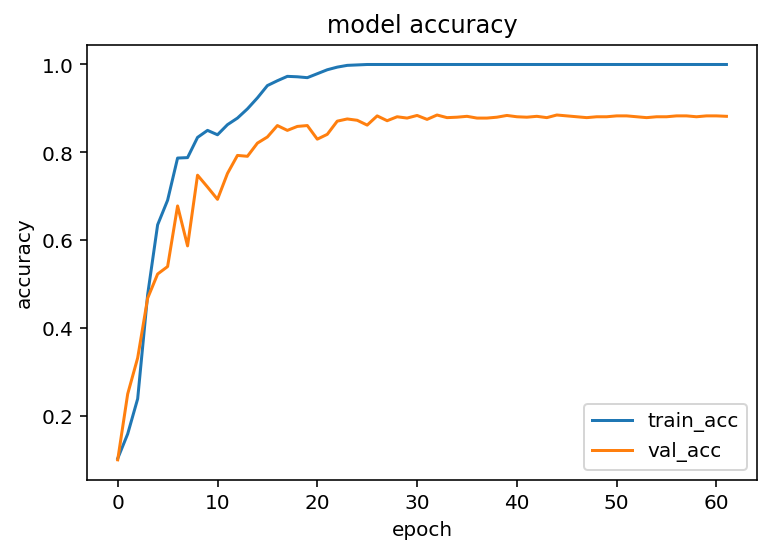

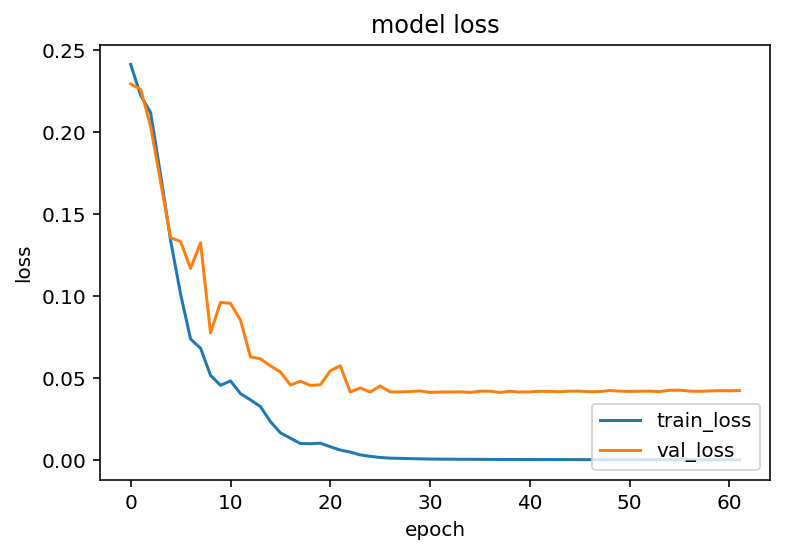

100%|██████████| 266/266 [00:15<00:00, 16.82it/s]
[2017-12-02 21:54:49,128 INFO] TestAcc: 0.8958 | TestLoss: 0.0360 


In [55]:
# set experimental params
epochs = 1000
lr = 0.5
momentum = 0.9
ex_name = 'supervised'
trial_times = 10

logzero.logfile('./log/{}.log'.format(ex_name))

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

results = {}
results['acc'] = np.empty((trial_times))
results['loss'] = np.empty((trial_times))
for i in range(trial_times):
    train_dataset = MNISTDataset(X_train, y_train, transform)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_dataset = MNISTDataset(X_val, y_val, transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=test_batch_size, num_workers=num_workers)
    test_dataset = MNISTDataset(X_test, y_test, transform)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, num_workers=num_workers)

    model = Net()
    if use_gpu:
        model.cuda()

    def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
        torch.save(state, filename)

    criterion = nn.KLDivLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    tracker = TrainingTracker()

    start = time.time()

    for epoch in range(0, epochs):
        tracker.epoch = epoch

        _train(model, train_loader, criterion, optimizer, tracker)
        _validate(model, val_loader, criterion, tracker)

        # if latest accuracy is the best in history
        if len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) == 1:
            save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            })
        elif len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) >= 30:
            logger.info('Accuracy dose not improve for a long epochs')
            break

    logger.info('Train done.')
    logger.info('Elapsed Time: {}'.format(time.time() - start))
    tracker.plot_history()
    
    model = Net()
    resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
    model.load_state_dict(resume['state_dict'])
    results['acc'][i], results['loss'][i] = _test(model, test_loader, criterion)

# Make Pseudo Label

In [56]:
logger.info('Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results['acc']),
    np.std(results['acc'])
))

logger.info('Loss: {:.4f} ± {:.4f}'.format(
    np.mean(results['loss']),
    np.std(results['loss'])
))

model = Net()
resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
model.load_state_dict(resume['state_dict'])
_test(model, test_loader, criterion, make_pl=True)

[2017-12-02 21:54:49,225 INFO] Accuracy: 0.8922 ± 0.0094
[2017-12-02 21:54:49,227 INFO] Loss: 0.0381 ± 0.0039
100%|██████████| 266/266 [00:14<00:00, 18.15it/s]
[2017-12-02 21:55:03,948 INFO] TestAcc: 0.8958 | TestLoss: 0.0360 


(0.8957941176470589, 0.035966883671634337)

## by many models prediction

[2017-12-04 17:45:17,633 INFO] Epoch: 0 | TrainAcc: 0.1270 | TrainLoss: 0.2471
[2017-12-04 17:45:17,991 INFO] Epoch: 0 | ValAcc: 0.1300 | ValLoss: 0.2296 

[2017-12-04 17:45:18,701 INFO] Epoch: 1 | TrainAcc: 0.1380 | TrainLoss: 0.2242
[2017-12-04 17:45:19,048 INFO] Epoch: 1 | ValAcc: 0.2650 | ValLoss: 0.2214 

[2017-12-04 17:45:19,809 INFO] Epoch: 2 | TrainAcc: 0.3960 | TrainLoss: 0.2050
[2017-12-04 17:45:20,173 INFO] Epoch: 2 | ValAcc: 0.4000 | ValLoss: 0.1997 

[2017-12-04 17:45:20,875 INFO] Epoch: 3 | TrainAcc: 0.5030 | TrainLoss: 0.1702
[2017-12-04 17:45:21,201 INFO] Epoch: 3 | ValAcc: 0.4920 | ValLoss: 0.1651 

[2017-12-04 17:45:21,875 INFO] Epoch: 4 | TrainAcc: 0.5940 | TrainLoss: 0.1303
[2017-12-04 17:45:22,207 INFO] Epoch: 4 | ValAcc: 0.3100 | ValLoss: 0.1973 

[2017-12-04 17:45:22,941 INFO] Epoch: 5 | TrainAcc: 0.6970 | TrainLoss: 0.0963
[2017-12-04 17:45:23,309 INFO] Epoch: 5 | ValAcc: 0.5280 | ValLoss: 0.1391 

[2017-12-04 17:45:24,082 INFO] Epoch: 6 | TrainAcc: 0.7220 | Tra

[2017-12-04 17:46:12,365 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:46:12,713 INFO] Epoch: 52 | ValAcc: 0.8840 | ValLoss: 0.0423 

[2017-12-04 17:46:13,384 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:46:13,707 INFO] Epoch: 53 | ValAcc: 0.8880 | ValLoss: 0.0420 

[2017-12-04 17:46:14,370 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:46:14,695 INFO] Epoch: 54 | ValAcc: 0.8820 | ValLoss: 0.0425 

[2017-12-04 17:46:15,337 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:46:15,656 INFO] Epoch: 55 | ValAcc: 0.8830 | ValLoss: 0.0426 

[2017-12-04 17:46:16,331 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:46:16,655 INFO] Epoch: 56 | ValAcc: 0.8870 | ValLoss: 0.0428 

[2017-12-04 17:46:17,319 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:46:17,641 INFO] Epoch: 57 | ValAcc: 0.8850 | ValLoss: 0.0429 

[2017-12-04 17:46:18,291 INFO] Epoch: 58 | TrainAcc:

[2017-12-04 17:47:04,551 INFO] Epoch: 104 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 17:47:04,886 INFO] Epoch: 104 | ValAcc: 0.8880 | ValLoss: 0.0449 

[2017-12-04 17:47:05,530 INFO] Epoch: 105 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 17:47:05,855 INFO] Epoch: 105 | ValAcc: 0.8890 | ValLoss: 0.0450 

[2017-12-04 17:47:06,501 INFO] Epoch: 106 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 17:47:06,818 INFO] Epoch: 106 | ValAcc: 0.8880 | ValLoss: 0.0451 

[2017-12-04 17:47:07,465 INFO] Epoch: 107 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 17:47:07,790 INFO] Epoch: 107 | ValAcc: 0.8890 | ValLoss: 0.0451 

[2017-12-04 17:47:08,472 INFO] Epoch: 108 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 17:47:08,794 INFO] Epoch: 108 | ValAcc: 0.8890 | ValLoss: 0.0452 

[2017-12-04 17:47:09,466 INFO] Epoch: 109 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 17:47:09,797 INFO] Epoch: 109 | ValAcc: 0.8850 | ValLoss: 0.0454 

[2017-12-04 17:47:10,450 INFO] Epoch: 11

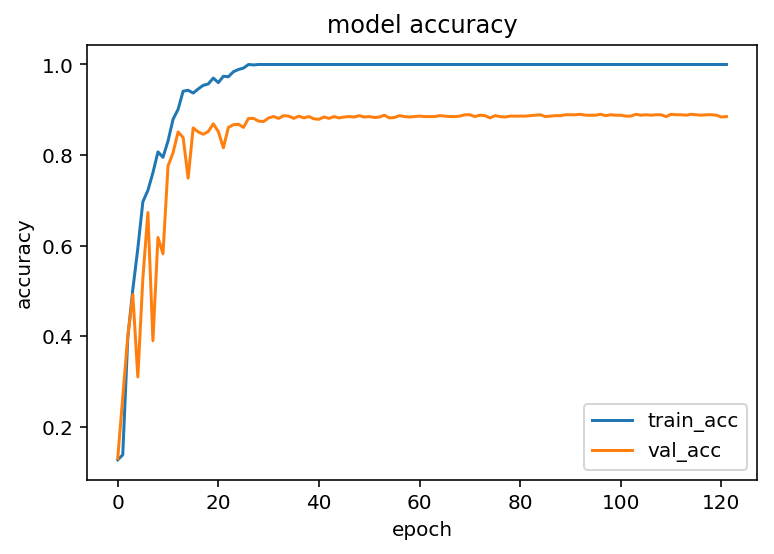

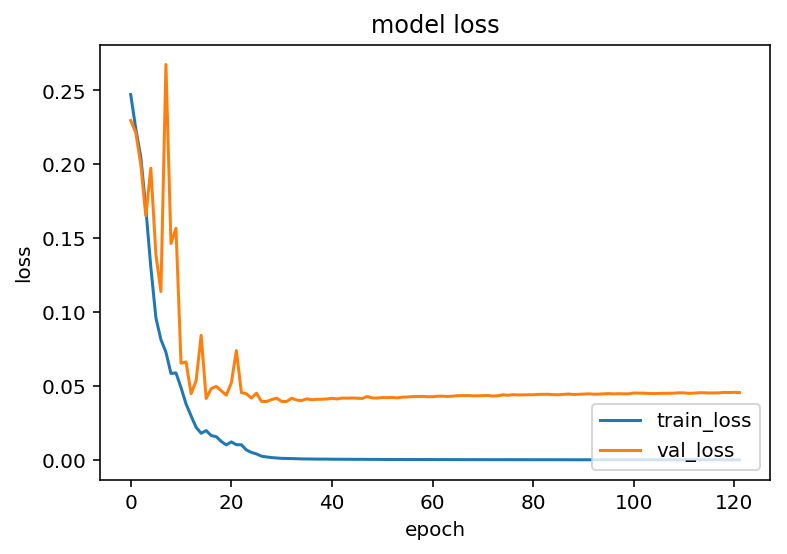

100%|██████████| 266/266 [00:14<00:00, 17.77it/s]
[2017-12-04 17:47:36,956 INFO] TestAcc: 0.8850 | TestLoss: 0.0467 
[2017-12-04 17:47:37,631 INFO] Epoch: 0 | TrainAcc: 0.1340 | TrainLoss: 0.2558
[2017-12-04 17:47:37,960 INFO] Epoch: 0 | ValAcc: 0.1000 | ValLoss: 0.2295 

[2017-12-04 17:47:38,627 INFO] Epoch: 1 | TrainAcc: 0.2030 | TrainLoss: 0.2216
[2017-12-04 17:47:38,949 INFO] Epoch: 1 | ValAcc: 0.2560 | ValLoss: 0.2233 

[2017-12-04 17:47:39,623 INFO] Epoch: 2 | TrainAcc: 0.3600 | TrainLoss: 0.2048
[2017-12-04 17:47:39,948 INFO] Epoch: 2 | ValAcc: 0.3690 | ValLoss: 0.2002 

[2017-12-04 17:47:40,654 INFO] Epoch: 3 | TrainAcc: 0.4620 | TrainLoss: 0.1758
[2017-12-04 17:47:40,992 INFO] Epoch: 3 | ValAcc: 0.3260 | ValLoss: 0.1829 

[2017-12-04 17:47:41,674 INFO] Epoch: 4 | TrainAcc: 0.5630 | TrainLoss: 0.1396
[2017-12-04 17:47:41,997 INFO] Epoch: 4 | ValAcc: 0.4460 | ValLoss: 0.1564 

[2017-12-04 17:47:42,657 INFO] Epoch: 5 | TrainAcc: 0.6550 | TrainLoss: 0.1086
[2017-12-04 17:47:42,977

[2017-12-04 17:48:29,243 INFO] Epoch: 51 | ValAcc: 0.8940 | ValLoss: 0.0396 

[2017-12-04 17:48:29,906 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:48:30,236 INFO] Epoch: 52 | ValAcc: 0.8960 | ValLoss: 0.0394 

[2017-12-04 17:48:30,935 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:48:31,273 INFO] Epoch: 53 | ValAcc: 0.8940 | ValLoss: 0.0396 

[2017-12-04 17:48:31,986 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:48:32,316 INFO] Epoch: 54 | ValAcc: 0.8930 | ValLoss: 0.0400 

[2017-12-04 17:48:33,036 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:48:33,364 INFO] Epoch: 55 | ValAcc: 0.8970 | ValLoss: 0.0397 

[2017-12-04 17:48:34,040 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:48:34,371 INFO] Epoch: 56 | ValAcc: 0.8940 | ValLoss: 0.0401 

[2017-12-04 17:48:34,386 INFO] Accuracy dose not improve for a long epochs
[2017-12-04 17:48:34,387 INFO] Train done.
[2017-12-04 17

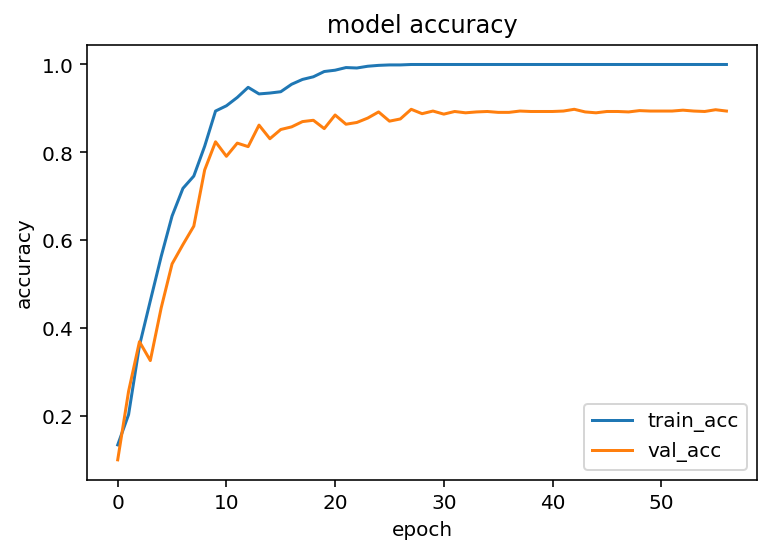

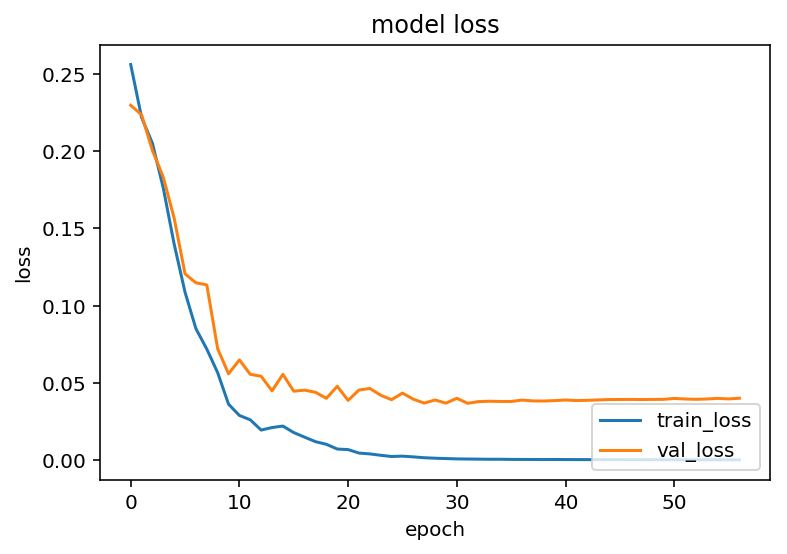

100%|██████████| 266/266 [00:14<00:00, 18.04it/s]
[2017-12-04 17:48:49,430 INFO] TestAcc: 0.9013 | TestLoss: 0.0336 
[2017-12-04 17:48:50,101 INFO] Epoch: 0 | TrainAcc: 0.1120 | TrainLoss: 0.2445
[2017-12-04 17:48:50,422 INFO] Epoch: 0 | ValAcc: 0.1010 | ValLoss: 0.2295 

[2017-12-04 17:48:51,103 INFO] Epoch: 1 | TrainAcc: 0.1420 | TrainLoss: 0.2225
[2017-12-04 17:48:51,421 INFO] Epoch: 1 | ValAcc: 0.2480 | ValLoss: 0.2203 

[2017-12-04 17:48:52,076 INFO] Epoch: 2 | TrainAcc: 0.3270 | TrainLoss: 0.2055
[2017-12-04 17:48:52,401 INFO] Epoch: 2 | ValAcc: 0.3600 | ValLoss: 0.2024 

[2017-12-04 17:48:53,082 INFO] Epoch: 3 | TrainAcc: 0.3980 | TrainLoss: 0.1809
[2017-12-04 17:48:53,423 INFO] Epoch: 3 | ValAcc: 0.4210 | ValLoss: 0.1760 

[2017-12-04 17:48:54,139 INFO] Epoch: 4 | TrainAcc: 0.5240 | TrainLoss: 0.1500
[2017-12-04 17:48:54,460 INFO] Epoch: 4 | ValAcc: 0.4550 | ValLoss: 0.1487 

[2017-12-04 17:48:55,131 INFO] Epoch: 5 | TrainAcc: 0.5780 | TrainLoss: 0.1242
[2017-12-04 17:48:55,455

[2017-12-04 17:49:43,901 INFO] Epoch: 51 | ValAcc: 0.8910 | ValLoss: 0.0390 

[2017-12-04 17:49:44,606 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:49:44,995 INFO] Epoch: 52 | ValAcc: 0.8860 | ValLoss: 0.0390 

[2017-12-04 17:49:45,716 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:49:46,095 INFO] Epoch: 53 | ValAcc: 0.8870 | ValLoss: 0.0388 

[2017-12-04 17:49:46,790 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:49:47,180 INFO] Epoch: 54 | ValAcc: 0.8880 | ValLoss: 0.0391 

[2017-12-04 17:49:47,931 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:49:48,351 INFO] Epoch: 55 | ValAcc: 0.8880 | ValLoss: 0.0392 

[2017-12-04 17:49:49,101 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:49:49,469 INFO] Epoch: 56 | ValAcc: 0.8900 | ValLoss: 0.0387 

[2017-12-04 17:49:50,208 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:49:50,552 INFO] Epoch: 57 | ValAcc: 0

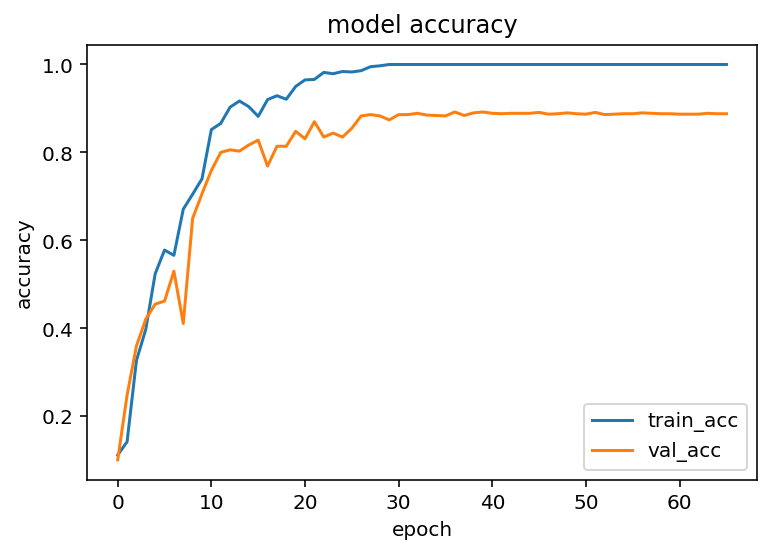

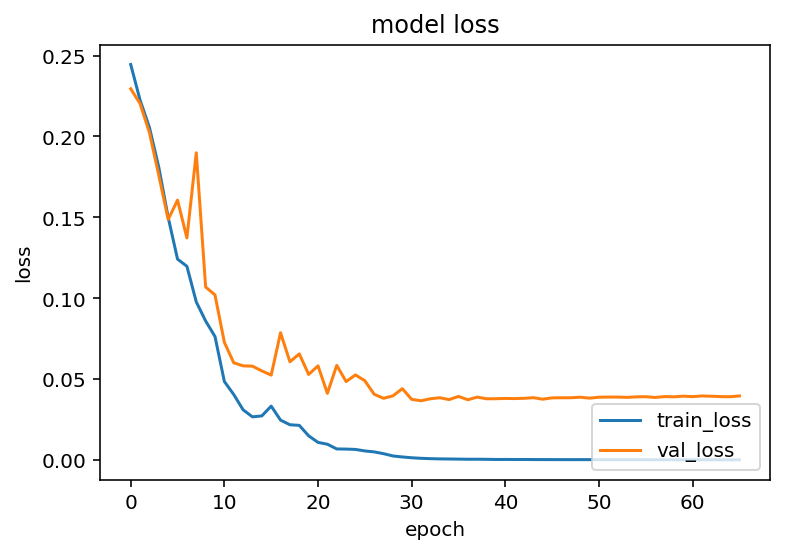

100%|██████████| 266/266 [00:15<00:00, 17.31it/s]
[2017-12-04 17:50:14,718 INFO] TestAcc: 0.8947 | TestLoss: 0.0384 
[2017-12-04 17:50:15,411 INFO] Epoch: 0 | TrainAcc: 0.1070 | TrainLoss: 0.2453
[2017-12-04 17:50:15,741 INFO] Epoch: 0 | ValAcc: 0.1580 | ValLoss: 0.2274 

[2017-12-04 17:50:16,395 INFO] Epoch: 1 | TrainAcc: 0.2080 | TrainLoss: 0.2224
[2017-12-04 17:50:16,718 INFO] Epoch: 1 | ValAcc: 0.2060 | ValLoss: 0.2181 

[2017-12-04 17:50:17,386 INFO] Epoch: 2 | TrainAcc: 0.2880 | TrainLoss: 0.2052
[2017-12-04 17:50:17,701 INFO] Epoch: 2 | ValAcc: 0.2390 | ValLoss: 0.2045 

[2017-12-04 17:50:18,362 INFO] Epoch: 3 | TrainAcc: 0.3570 | TrainLoss: 0.1866
[2017-12-04 17:50:18,674 INFO] Epoch: 3 | ValAcc: 0.3190 | ValLoss: 0.1823 

[2017-12-04 17:50:19,343 INFO] Epoch: 4 | TrainAcc: 0.4520 | TrainLoss: 0.1621
[2017-12-04 17:50:19,662 INFO] Epoch: 4 | ValAcc: 0.2750 | ValLoss: 0.2022 

[2017-12-04 17:50:20,318 INFO] Epoch: 5 | TrainAcc: 0.5200 | TrainLoss: 0.1451
[2017-12-04 17:50:20,638

[2017-12-04 17:51:10,641 INFO] Epoch: 51 | ValAcc: 0.8710 | ValLoss: 0.0499 

[2017-12-04 17:51:11,314 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:51:11,834 INFO] Epoch: 52 | ValAcc: 0.8710 | ValLoss: 0.0504 

[2017-12-04 17:51:12,907 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:51:13,253 INFO] Epoch: 53 | ValAcc: 0.8700 | ValLoss: 0.0504 

[2017-12-04 17:51:14,009 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:51:14,517 INFO] Epoch: 54 | ValAcc: 0.8700 | ValLoss: 0.0512 

[2017-12-04 17:51:15,679 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:51:16,036 INFO] Epoch: 55 | ValAcc: 0.8690 | ValLoss: 0.0508 

[2017-12-04 17:51:16,755 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:51:17,104 INFO] Epoch: 56 | ValAcc: 0.8700 | ValLoss: 0.0503 

[2017-12-04 17:51:17,782 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:51:18,102 INFO] Epoch: 57 | ValAcc: 0

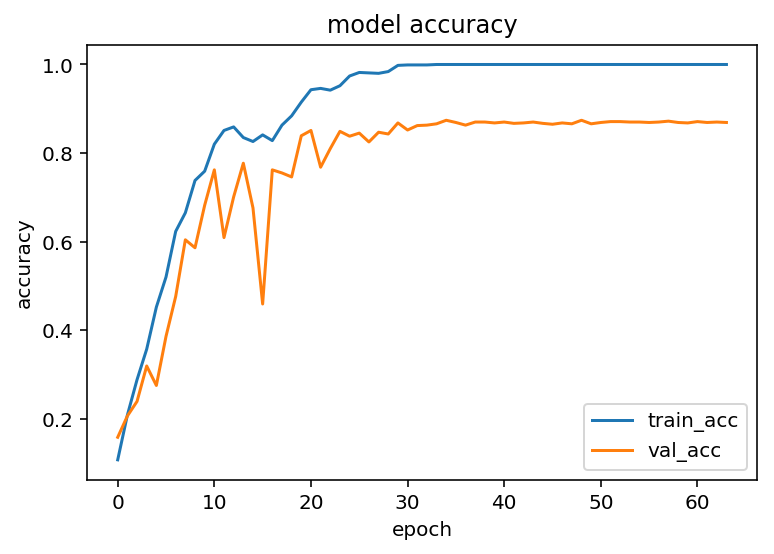

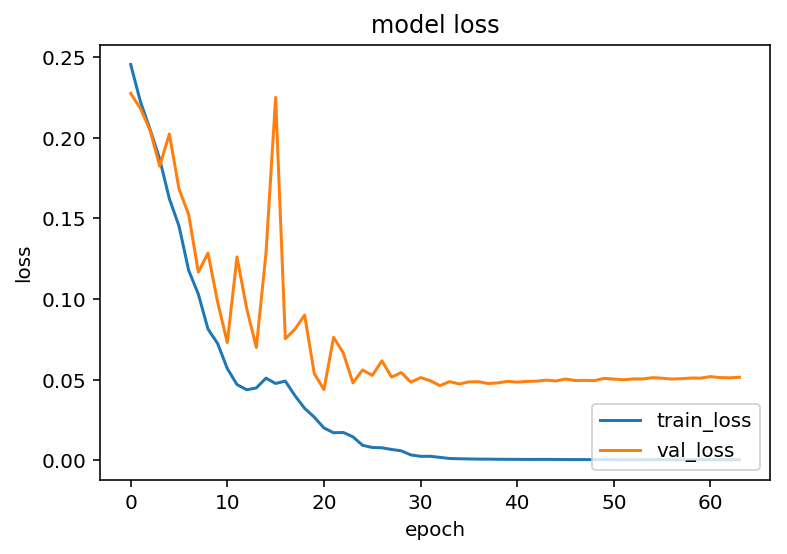

100%|██████████| 266/266 [00:16<00:00, 16.44it/s]
[2017-12-04 17:51:41,392 INFO] TestAcc: 0.8729 | TestLoss: 0.0449 
[2017-12-04 17:51:42,072 INFO] Epoch: 0 | TrainAcc: 0.1290 | TrainLoss: 0.2611
[2017-12-04 17:51:42,408 INFO] Epoch: 0 | ValAcc: 0.1690 | ValLoss: 0.2306 

[2017-12-04 17:51:43,121 INFO] Epoch: 1 | TrainAcc: 0.1200 | TrainLoss: 0.2288
[2017-12-04 17:51:43,451 INFO] Epoch: 1 | ValAcc: 0.1910 | ValLoss: 0.2226 

[2017-12-04 17:51:44,156 INFO] Epoch: 2 | TrainAcc: 0.2900 | TrainLoss: 0.2133
[2017-12-04 17:51:44,483 INFO] Epoch: 2 | ValAcc: 0.3080 | ValLoss: 0.2114 

[2017-12-04 17:51:45,168 INFO] Epoch: 3 | TrainAcc: 0.3850 | TrainLoss: 0.1942
[2017-12-04 17:51:45,488 INFO] Epoch: 3 | ValAcc: 0.3320 | ValLoss: 0.1878 

[2017-12-04 17:51:46,149 INFO] Epoch: 4 | TrainAcc: 0.5050 | TrainLoss: 0.1625
[2017-12-04 17:51:46,473 INFO] Epoch: 4 | ValAcc: 0.4170 | ValLoss: 0.1640 

[2017-12-04 17:51:47,134 INFO] Epoch: 5 | TrainAcc: 0.6130 | TrainLoss: 0.1268
[2017-12-04 17:51:47,477

[2017-12-04 17:52:35,025 INFO] Epoch: 51 | ValAcc: 0.8770 | ValLoss: 0.0515 

[2017-12-04 17:52:35,685 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 17:52:36,005 INFO] Epoch: 52 | ValAcc: 0.8750 | ValLoss: 0.0523 

[2017-12-04 17:52:36,659 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:52:36,984 INFO] Epoch: 53 | ValAcc: 0.8790 | ValLoss: 0.0511 

[2017-12-04 17:52:37,631 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:52:37,985 INFO] Epoch: 54 | ValAcc: 0.8790 | ValLoss: 0.0521 

[2017-12-04 17:52:38,650 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:52:38,976 INFO] Epoch: 55 | ValAcc: 0.8740 | ValLoss: 0.0525 

[2017-12-04 17:52:39,640 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:52:39,968 INFO] Epoch: 56 | ValAcc: 0.8810 | ValLoss: 0.0507 

[2017-12-04 17:52:40,627 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:52:40,948 INFO] Epoch: 57 | ValAcc: 0

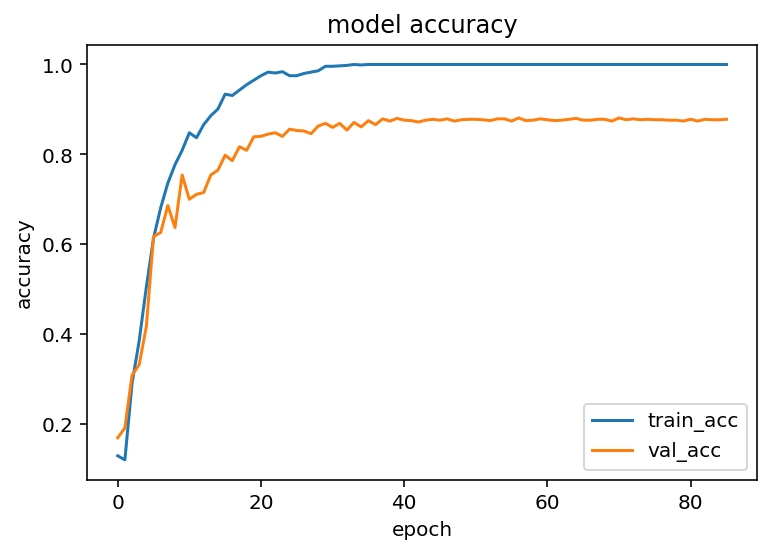

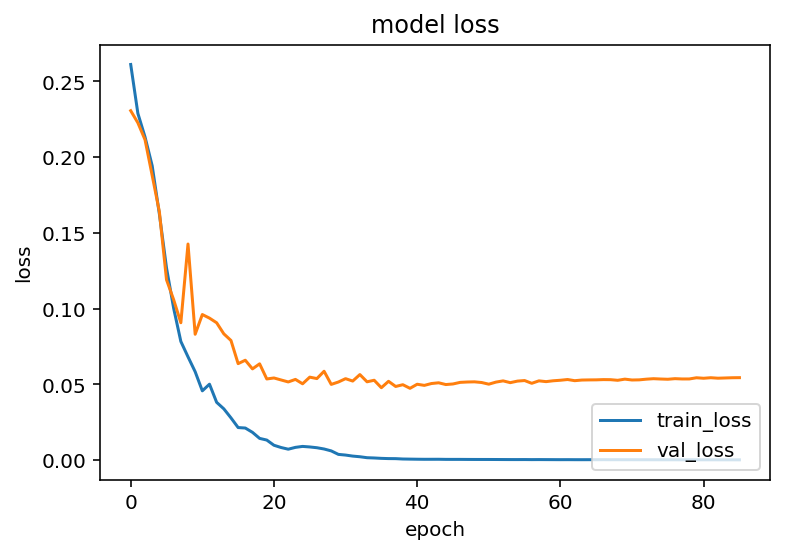

100%|██████████| 266/266 [00:14<00:00, 18.04it/s]
[2017-12-04 17:53:23,821 INFO] TestAcc: 0.8879 | TestLoss: 0.0440 
[2017-12-04 17:53:24,500 INFO] Epoch: 0 | TrainAcc: 0.1380 | TrainLoss: 0.2342
[2017-12-04 17:53:24,825 INFO] Epoch: 0 | ValAcc: 0.2280 | ValLoss: 0.2276 

[2017-12-04 17:53:25,499 INFO] Epoch: 1 | TrainAcc: 0.2960 | TrainLoss: 0.2052
[2017-12-04 17:53:25,846 INFO] Epoch: 1 | ValAcc: 0.3570 | ValLoss: 0.2112 

[2017-12-04 17:53:26,587 INFO] Epoch: 2 | TrainAcc: 0.5120 | TrainLoss: 0.1612
[2017-12-04 17:53:26,910 INFO] Epoch: 2 | ValAcc: 0.5140 | ValLoss: 0.1658 

[2017-12-04 17:53:27,615 INFO] Epoch: 3 | TrainAcc: 0.6760 | TrainLoss: 0.1101
[2017-12-04 17:53:27,989 INFO] Epoch: 3 | ValAcc: 0.6480 | ValLoss: 0.1144 

[2017-12-04 17:53:28,698 INFO] Epoch: 4 | TrainAcc: 0.7670 | TrainLoss: 0.0766
[2017-12-04 17:53:29,053 INFO] Epoch: 4 | ValAcc: 0.6670 | ValLoss: 0.0870 

[2017-12-04 17:53:29,718 INFO] Epoch: 5 | TrainAcc: 0.8440 | TrainLoss: 0.0537
[2017-12-04 17:53:30,042

[2017-12-04 17:54:16,961 INFO] Epoch: 51 | ValAcc: 0.8990 | ValLoss: 0.0336 

[2017-12-04 17:54:17,667 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:54:18,012 INFO] Epoch: 52 | ValAcc: 0.9000 | ValLoss: 0.0339 

[2017-12-04 17:54:18,731 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:54:19,048 INFO] Epoch: 53 | ValAcc: 0.9010 | ValLoss: 0.0335 

[2017-12-04 17:54:19,722 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:54:20,042 INFO] Epoch: 54 | ValAcc: 0.9010 | ValLoss: 0.0338 

[2017-12-04 17:54:20,705 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:54:21,033 INFO] Epoch: 55 | ValAcc: 0.8990 | ValLoss: 0.0337 

[2017-12-04 17:54:21,048 INFO] Accuracy dose not improve for a long epochs
[2017-12-04 17:54:21,050 INFO] Train done.
[2017-12-04 17:54:21,051 INFO] Elapsed Time: 57.197221755981445


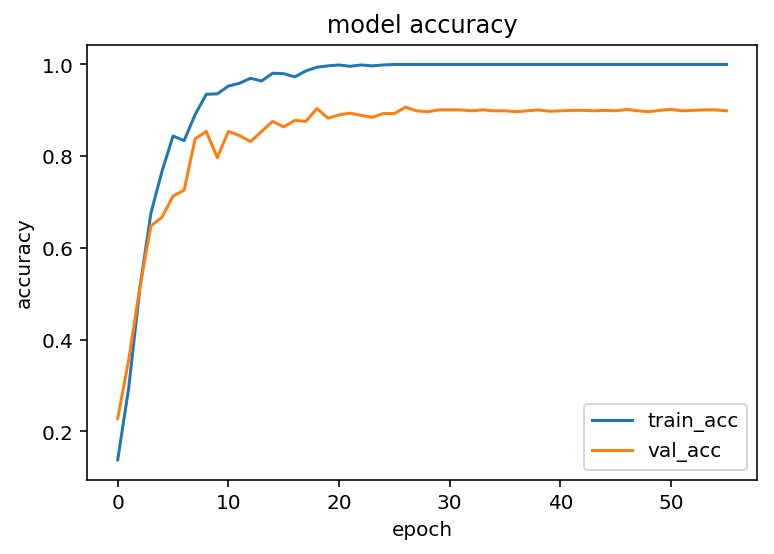

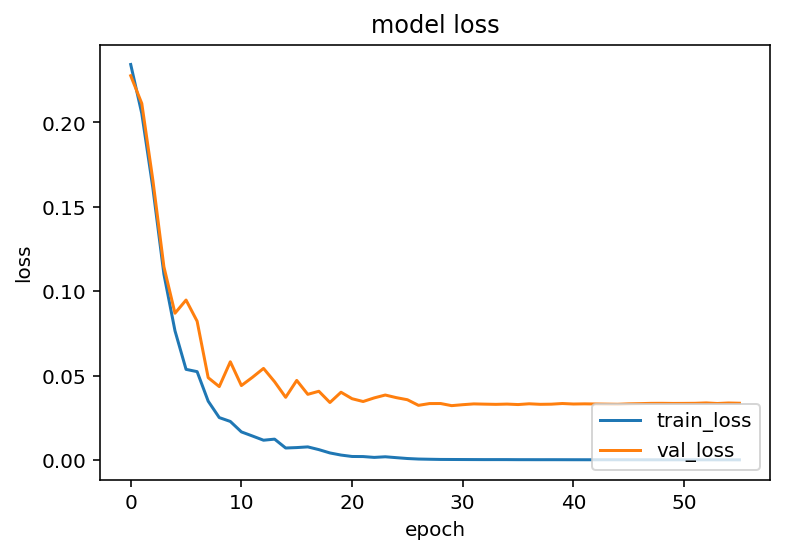

100%|██████████| 266/266 [00:15<00:00, 17.33it/s]
[2017-12-04 17:54:36,763 INFO] TestAcc: 0.9127 | TestLoss: 0.0300 
[2017-12-04 17:54:37,442 INFO] Epoch: 0 | TrainAcc: 0.1200 | TrainLoss: 0.2411
[2017-12-04 17:54:37,764 INFO] Epoch: 0 | ValAcc: 0.1510 | ValLoss: 0.2271 

[2017-12-04 17:54:38,470 INFO] Epoch: 1 | TrainAcc: 0.3040 | TrainLoss: 0.2057
[2017-12-04 17:54:38,821 INFO] Epoch: 1 | ValAcc: 0.3120 | ValLoss: 0.2065 

[2017-12-04 17:54:39,535 INFO] Epoch: 2 | TrainAcc: 0.4210 | TrainLoss: 0.1702
[2017-12-04 17:54:39,882 INFO] Epoch: 2 | ValAcc: 0.4770 | ValLoss: 0.1620 

[2017-12-04 17:54:40,581 INFO] Epoch: 3 | TrainAcc: 0.5730 | TrainLoss: 0.1297
[2017-12-04 17:54:40,906 INFO] Epoch: 3 | ValAcc: 0.5420 | ValLoss: 0.1345 

[2017-12-04 17:54:41,575 INFO] Epoch: 4 | TrainAcc: 0.6750 | TrainLoss: 0.0989
[2017-12-04 17:54:41,898 INFO] Epoch: 4 | ValAcc: 0.6670 | ValLoss: 0.0934 

[2017-12-04 17:54:42,562 INFO] Epoch: 5 | TrainAcc: 0.7780 | TrainLoss: 0.0710
[2017-12-04 17:54:42,885

[2017-12-04 17:55:29,365 INFO] Epoch: 51 | ValAcc: 0.8960 | ValLoss: 0.0379 

[2017-12-04 17:55:30,178 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:55:30,526 INFO] Epoch: 52 | ValAcc: 0.8980 | ValLoss: 0.0381 

[2017-12-04 17:55:31,212 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:55:31,535 INFO] Epoch: 53 | ValAcc: 0.8950 | ValLoss: 0.0382 

[2017-12-04 17:55:32,268 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:55:32,615 INFO] Epoch: 54 | ValAcc: 0.8940 | ValLoss: 0.0383 

[2017-12-04 17:55:33,274 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:55:33,598 INFO] Epoch: 55 | ValAcc: 0.8960 | ValLoss: 0.0383 

[2017-12-04 17:55:34,276 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:55:34,634 INFO] Epoch: 56 | ValAcc: 0.8990 | ValLoss: 0.0381 

[2017-12-04 17:55:35,383 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:55:35,717 INFO] Epoch: 57 | ValAcc: 0

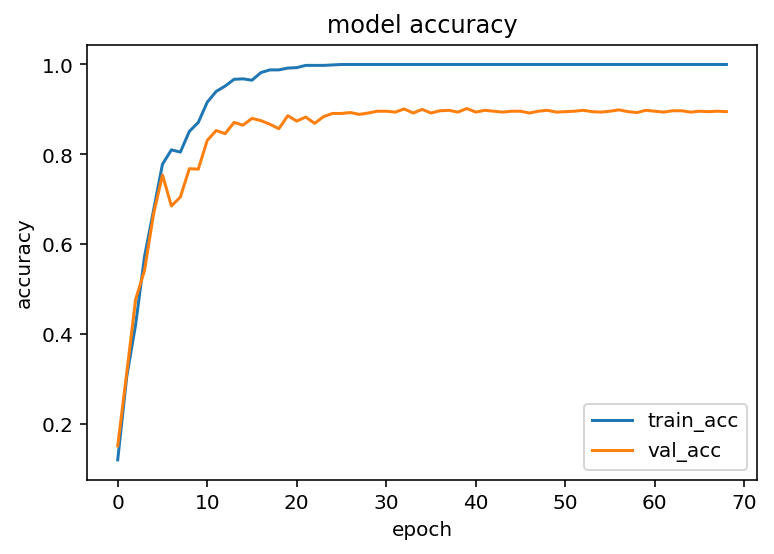

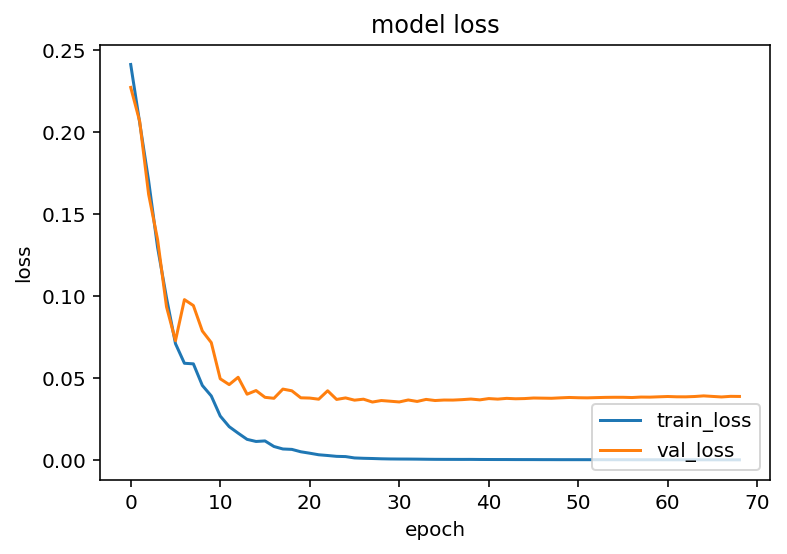

100%|██████████| 266/266 [00:14<00:00, 18.16it/s]
[2017-12-04 17:56:01,705 INFO] TestAcc: 0.9024 | TestLoss: 0.0344 
[2017-12-04 17:56:02,384 INFO] Epoch: 0 | TrainAcc: 0.1190 | TrainLoss: 0.2466
[2017-12-04 17:56:02,725 INFO] Epoch: 0 | ValAcc: 0.1010 | ValLoss: 0.2298 

[2017-12-04 17:56:03,423 INFO] Epoch: 1 | TrainAcc: 0.1830 | TrainLoss: 0.2312
[2017-12-04 17:56:03,800 INFO] Epoch: 1 | ValAcc: 0.1980 | ValLoss: 0.2242 

[2017-12-04 17:56:04,502 INFO] Epoch: 2 | TrainAcc: 0.2950 | TrainLoss: 0.2130
[2017-12-04 17:56:04,824 INFO] Epoch: 2 | ValAcc: 0.3640 | ValLoss: 0.2106 

[2017-12-04 17:56:05,517 INFO] Epoch: 3 | TrainAcc: 0.3800 | TrainLoss: 0.1928
[2017-12-04 17:56:05,835 INFO] Epoch: 3 | ValAcc: 0.3840 | ValLoss: 0.1856 

[2017-12-04 17:56:06,482 INFO] Epoch: 4 | TrainAcc: 0.5230 | TrainLoss: 0.1577
[2017-12-04 17:56:06,803 INFO] Epoch: 4 | ValAcc: 0.5450 | ValLoss: 0.1497 

[2017-12-04 17:56:07,477 INFO] Epoch: 5 | TrainAcc: 0.5970 | TrainLoss: 0.1240
[2017-12-04 17:56:07,800

[2017-12-04 17:56:55,445 INFO] Epoch: 51 | ValAcc: 0.8960 | ValLoss: 0.0401 

[2017-12-04 17:56:56,214 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:56:56,577 INFO] Epoch: 52 | ValAcc: 0.8950 | ValLoss: 0.0403 

[2017-12-04 17:56:57,366 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:56:57,755 INFO] Epoch: 53 | ValAcc: 0.8940 | ValLoss: 0.0399 

[2017-12-04 17:56:58,495 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:56:58,861 INFO] Epoch: 54 | ValAcc: 0.8950 | ValLoss: 0.0402 

[2017-12-04 17:56:59,611 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:56:59,931 INFO] Epoch: 55 | ValAcc: 0.8980 | ValLoss: 0.0402 

[2017-12-04 17:57:00,601 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:57:00,923 INFO] Epoch: 56 | ValAcc: 0.8930 | ValLoss: 0.0403 

[2017-12-04 17:57:01,583 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:57:01,909 INFO] Epoch: 57 | ValAcc: 0

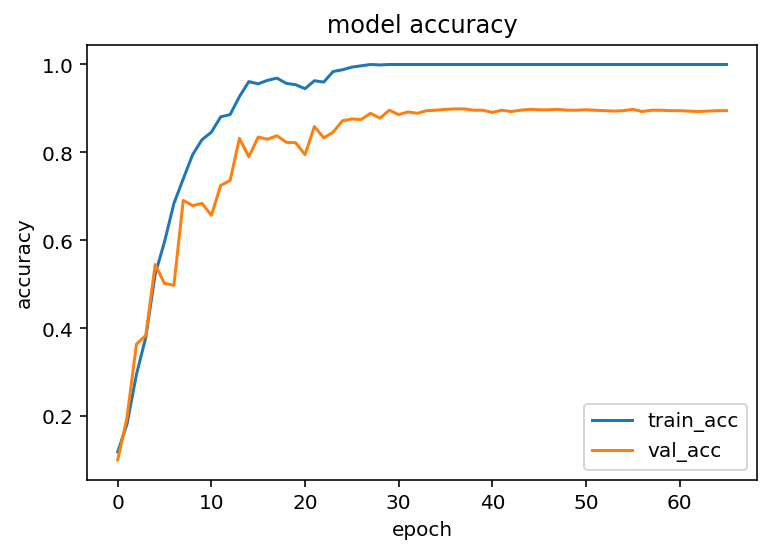

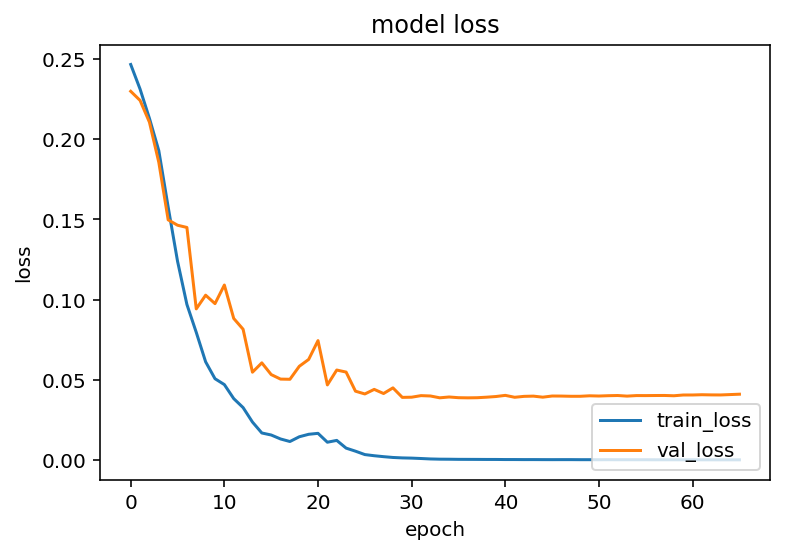

100%|██████████| 266/266 [00:14<00:00, 18.09it/s]
[2017-12-04 17:57:25,042 INFO] TestAcc: 0.8897 | TestLoss: 0.0398 
[2017-12-04 17:57:25,740 INFO] Epoch: 0 | TrainAcc: 0.1540 | TrainLoss: 0.2320
[2017-12-04 17:57:26,075 INFO] Epoch: 0 | ValAcc: 0.1150 | ValLoss: 0.2278 

[2017-12-04 17:57:26,736 INFO] Epoch: 1 | TrainAcc: 0.2720 | TrainLoss: 0.2080
[2017-12-04 17:57:27,056 INFO] Epoch: 1 | ValAcc: 0.2200 | ValLoss: 0.2146 

[2017-12-04 17:57:27,721 INFO] Epoch: 2 | TrainAcc: 0.3870 | TrainLoss: 0.1786
[2017-12-04 17:57:28,053 INFO] Epoch: 2 | ValAcc: 0.4580 | ValLoss: 0.1791 

[2017-12-04 17:57:28,751 INFO] Epoch: 3 | TrainAcc: 0.5490 | TrainLoss: 0.1400
[2017-12-04 17:57:29,072 INFO] Epoch: 3 | ValAcc: 0.4520 | ValLoss: 0.1553 

[2017-12-04 17:57:29,735 INFO] Epoch: 4 | TrainAcc: 0.6250 | TrainLoss: 0.1124
[2017-12-04 17:57:30,057 INFO] Epoch: 4 | ValAcc: 0.4040 | ValLoss: 0.1790 

[2017-12-04 17:57:30,727 INFO] Epoch: 5 | TrainAcc: 0.7130 | TrainLoss: 0.0869
[2017-12-04 17:57:31,075

[2017-12-04 17:58:18,068 INFO] Epoch: 51 | ValAcc: 0.8930 | ValLoss: 0.0401 

[2017-12-04 17:58:18,756 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:58:19,092 INFO] Epoch: 52 | ValAcc: 0.8910 | ValLoss: 0.0406 

[2017-12-04 17:58:19,793 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:58:20,164 INFO] Epoch: 53 | ValAcc: 0.8900 | ValLoss: 0.0407 

[2017-12-04 17:58:20,868 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:58:21,204 INFO] Epoch: 54 | ValAcc: 0.8940 | ValLoss: 0.0405 

[2017-12-04 17:58:21,892 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 17:58:22,234 INFO] Epoch: 55 | ValAcc: 0.8890 | ValLoss: 0.0410 

[2017-12-04 17:58:22,933 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:58:23,282 INFO] Epoch: 56 | ValAcc: 0.8930 | ValLoss: 0.0405 

[2017-12-04 17:58:23,955 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 17:58:24,286 INFO] Epoch: 57 | ValAcc: 0

[2017-12-04 17:59:10,560 INFO] Epoch: 103 | ValAcc: 0.8960 | ValLoss: 0.0430 

[2017-12-04 17:59:11,243 INFO] Epoch: 104 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 17:59:11,560 INFO] Epoch: 104 | ValAcc: 0.8960 | ValLoss: 0.0432 

[2017-12-04 17:59:12,221 INFO] Epoch: 105 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 17:59:12,543 INFO] Epoch: 105 | ValAcc: 0.8970 | ValLoss: 0.0433 

[2017-12-04 17:59:13,199 INFO] Epoch: 106 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 17:59:13,518 INFO] Epoch: 106 | ValAcc: 0.8940 | ValLoss: 0.0431 

[2017-12-04 17:59:14,181 INFO] Epoch: 107 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 17:59:14,523 INFO] Epoch: 107 | ValAcc: 0.8960 | ValLoss: 0.0429 

[2017-12-04 17:59:15,184 INFO] Epoch: 108 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 17:59:15,521 INFO] Epoch: 108 | ValAcc: 0.8950 | ValLoss: 0.0432 

[2017-12-04 17:59:16,163 INFO] Epoch: 109 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 17:59:16,488 INFO] Epoch: 10

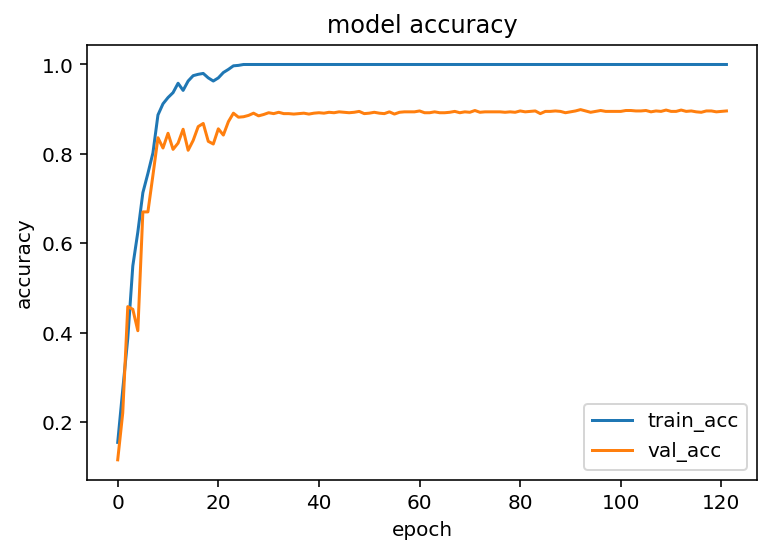

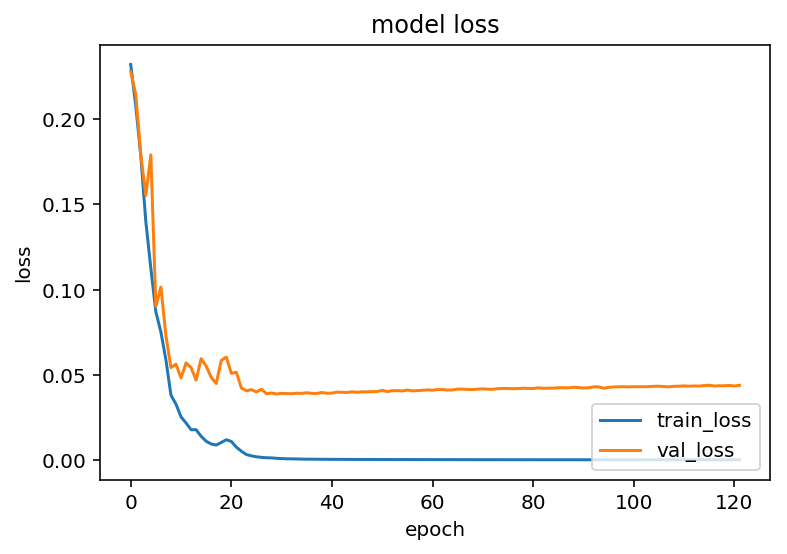

100%|██████████| 266/266 [00:14<00:00, 18.16it/s]
[2017-12-04 17:59:43,482 INFO] TestAcc: 0.8962 | TestLoss: 0.0412 
[2017-12-04 17:59:44,171 INFO] Epoch: 0 | TrainAcc: 0.1620 | TrainLoss: 0.2281
[2017-12-04 17:59:44,492 INFO] Epoch: 0 | ValAcc: 0.1240 | ValLoss: 0.2268 

[2017-12-04 17:59:45,148 INFO] Epoch: 1 | TrainAcc: 0.3330 | TrainLoss: 0.2028
[2017-12-04 17:59:45,475 INFO] Epoch: 1 | ValAcc: 0.4220 | ValLoss: 0.2044 

[2017-12-04 17:59:46,134 INFO] Epoch: 2 | TrainAcc: 0.5110 | TrainLoss: 0.1637
[2017-12-04 17:59:46,455 INFO] Epoch: 2 | ValAcc: 0.5340 | ValLoss: 0.1647 

[2017-12-04 17:59:47,109 INFO] Epoch: 3 | TrainAcc: 0.6100 | TrainLoss: 0.1278
[2017-12-04 17:59:47,450 INFO] Epoch: 3 | ValAcc: 0.5410 | ValLoss: 0.1274 

[2017-12-04 17:59:48,135 INFO] Epoch: 4 | TrainAcc: 0.6610 | TrainLoss: 0.1018
[2017-12-04 17:59:48,470 INFO] Epoch: 4 | ValAcc: 0.5800 | ValLoss: 0.1217 

[2017-12-04 17:59:49,134 INFO] Epoch: 5 | TrainAcc: 0.7680 | TrainLoss: 0.0720
[2017-12-04 17:59:49,454

[2017-12-04 18:00:37,844 INFO] Epoch: 51 | ValAcc: 0.8820 | ValLoss: 0.0448 

[2017-12-04 18:00:38,566 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 18:00:38,911 INFO] Epoch: 52 | ValAcc: 0.8850 | ValLoss: 0.0443 

[2017-12-04 18:00:39,606 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 18:00:39,935 INFO] Epoch: 53 | ValAcc: 0.8810 | ValLoss: 0.0446 

[2017-12-04 18:00:40,593 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 18:00:40,914 INFO] Epoch: 54 | ValAcc: 0.8830 | ValLoss: 0.0444 

[2017-12-04 18:00:41,568 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 18:00:41,886 INFO] Epoch: 55 | ValAcc: 0.8810 | ValLoss: 0.0449 

[2017-12-04 18:00:42,557 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 18:00:42,911 INFO] Epoch: 56 | ValAcc: 0.8830 | ValLoss: 0.0446 

[2017-12-04 18:00:43,713 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 18:00:44,055 INFO] Epoch: 57 | ValAcc: 0

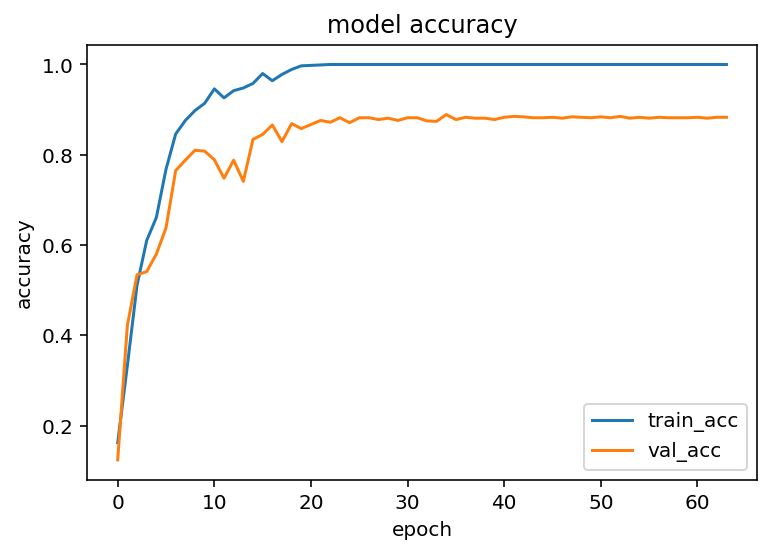

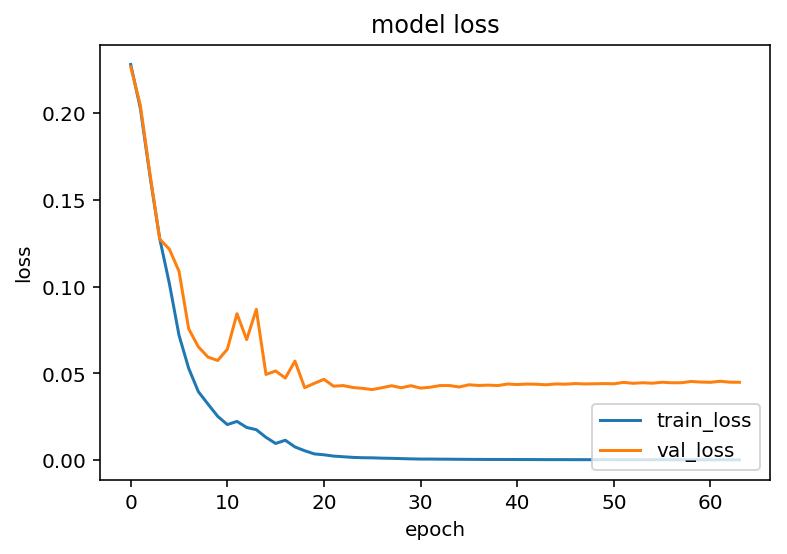

100%|██████████| 266/266 [00:15<00:00, 17.03it/s]
[2017-12-04 18:01:06,407 INFO] TestAcc: 0.8932 | TestLoss: 0.0377 


In [112]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = F.adaptive_max_pool2d(x, output_size=1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
def _train(model, data_loader, criterion, optimizer, tracker):
    model.train()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        log_softmax = F.log_softmax(output)
        loss = criterion(log_softmax, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=True, acc=acc, loss=loss.data[0], n=len(X))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    logger.info(
        'Epoch: {tracker.epoch} | '
        'TrainAcc: {tracker.train_acc:.4f} | '
        'TrainLoss: {tracker.train_loss:.4f}'.format(
            tracker=tracker)
    )
    tracker.history['train_acc'].append(tracker.train_acc)
    tracker.history['train_loss'] .append(tracker.train_loss)
    tracker.reset()

def _validate(model, data_loader, criterion, tracker):
    model.eval()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        log_softmax = F.log_softmax(output)
        loss = criterion(log_softmax, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=False, acc=acc, loss=loss.data[0], n=len(X))

    logger.info(
        'Epoch: {tracker.epoch} | '
        'ValAcc: {tracker.val_acc:.4f} | '
        'ValLoss: {tracker.val_loss:.4f} \n'.format(
            tracker=tracker)
    )
    tracker.history['val_acc'].append(tracker.val_acc)
    tracker.history['val_loss'].append(tracker.val_loss)
    tracker.reset()

def _test(trial_i, model, data_loader, criterion, make_pl=False, temperature=1):
    model.eval()
    
    if make_pl:
        pseudo_label = np.empty((0, 10))
    
    acc_sum = 0
    loss_sum = 0
    for i, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        log_softmax = F.log_softmax(output)
        loss = criterion(log_softmax, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc_sum += pred.eq(answer).sum()
        loss_sum += loss.data[0] * X.size(0)
        
        if make_pl:
            sm_temp = F.softmax(output / temperature)
            pseudo_label = np.concatenate([pseudo_label, sm_temp.data.numpy()], axis=0)

    acc = acc_sum / n_test
    loss = loss_sum / n_test
    logger.info(
        'TestAcc: {0:.4f} | '
        'TestLoss: {1:.4f} '.format(
            acc, loss)
    )
    
    if make_pl:
        np.save('./save/committee/pseudo_label_{}.npy'.format(trial_i), pseudo_label)
    
    return acc, loss 

# set seed for reproducibility
torch.manual_seed(2018)
np.random.seed(2018)

# set experimental params
epochs = 1000
lr = 0.5
momentum = 0.9
ex_name = 'committee'
trial_times = 10
temperature = 1.0

logzero.logfile('./log/{}.log'.format(ex_name))

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

results = {}
results['acc'] = np.empty((trial_times))
results['loss'] = np.empty((trial_times))
for i in range(trial_times):
    train_dataset = MNISTDataset(X_train, y_train, transform)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_dataset = MNISTDataset(X_val, y_val, transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=test_batch_size, num_workers=num_workers)
    test_dataset = MNISTDataset(X_test, y_test, transform)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, num_workers=num_workers)

    model = Net()
    if use_gpu:
        model.cuda()

    def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
        torch.save(state, filename)

    criterion = nn.KLDivLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    tracker = TrainingTracker()

    start = time.time()

    for epoch in range(0, epochs):
        tracker.epoch = epoch

        _train(model, train_loader, criterion, optimizer, tracker)
        _validate(model, val_loader, criterion, tracker)

        # if latest accuracy is the best in history
        if len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) == 1:
            save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            })
        elif len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) >= 30:
            logger.info('Accuracy dose not improve for a long epochs')
            break

    logger.info('Train done.')
    logger.info('Elapsed Time: {}'.format(time.time() - start))
    tracker.plot_history()
    
    model = Net()
    resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
    model.load_state_dict(resume['state_dict'])
    results['acc'][i], results['loss'][i] = _test(
        i, model, test_loader, criterion, make_pl=True, temperature=temperature)

# Some experiment about ensemble

In [183]:
npys = []
for i in range(10):
    npys.append(np.load('./save/committee/pseudo_label_{}.npy'.format(i)))
    
npys = np.array(npys)
npys.shape

(10, 68000, 10)

### single network performance

In [184]:
results['acc'].mean()

0.89359558823529406

### effect of ensemble

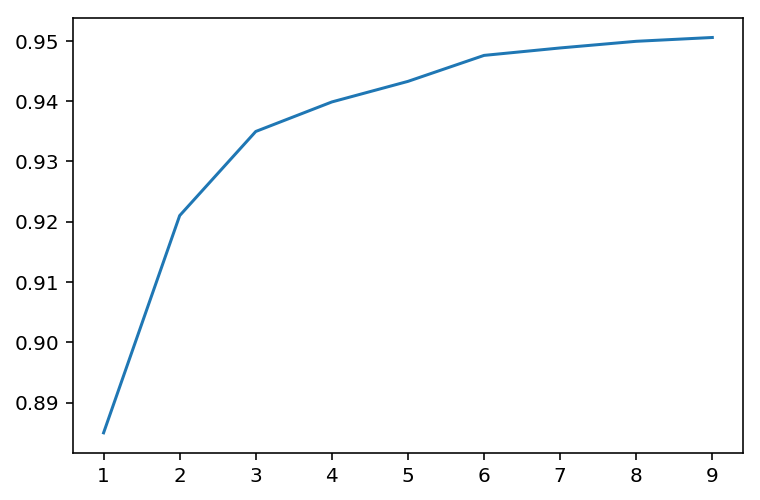

In [145]:
import  matplotlib.pyplot as plt
plt.plot(
    [i for i in range(1, 10)],
    [(np.argmax(y_test, axis=1) == np.argmax(np.mean(npys[:i], axis=0), axis=-1)).mean() for i in range(1, 10)],
)

Accuracy plot of the number of models

### accとモデル間の予測の分散の関係

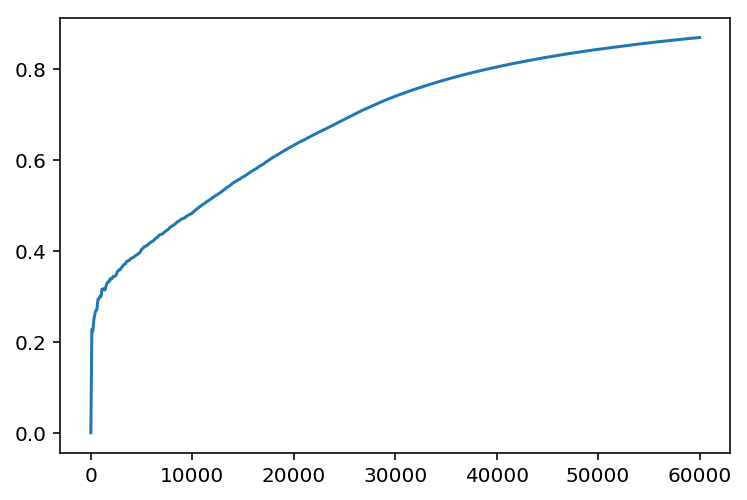

In [188]:
acc = []
x = np.arange(1, 60002, 100)
for i in x:
    idx = np.argsort(-np.std(npys, axis=0).mean(axis=-1))[:i]
    acc.append((np.argmax(y_test[idx], axis=-1) == np.argmax(npys[0, idx], axis=-1)).mean())
    
plt.plot(x, acc)

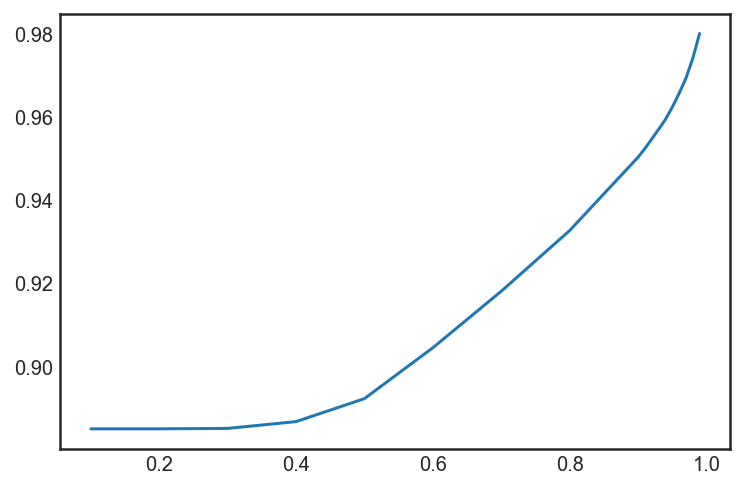

In [233]:
acc = []
probs = np.arange(0.1, 1.0, 0.1)
probs = np.concatenate([probs, np.arange(0.91, 1.0, 0.01)])
for prob in probs:
    idx = np.max(npys[0], axis=-1) > prob
    acc.append((np.argmax(y_test[idx], axis=-1) == 
                np.argmax(npys[0][idx], axis=-1)).mean())
    
plt.plot(x, acc)